(GLM-missing-values-in-covariates.ipynb)=
# GLM-missing-values-in-covariates

:::{post} Nov 09, 2024
:tags: missing-covariate-values, missing-values, auto-imputation, linear-regression, bayesian-workflow
:category: intermediate, reference
:author: Jonathan Sedar
:::

Minimal Reproducible Example: Workflow to handle missing data in multiple covariates (numeric predictor features)


## Automatic Imputation of Missing Values In Covariates: Worked Example with Bayesian Workflow

Here we demonstrate **automatic imputation of missing values within multiple covariates (numeric predictor features)**:

```
y ~ x + e
y: Numeric target
x: Numeric with missing values in covariates (numeric predictor features)
```

**Disclaimer:**
+ This Notebook is a worked example only, it's not intended to be an academic reference
+ The theory and math may be incorrect, incorrectly notated, or incorrectly used
+ The code may contain errors, inefficiencies, legacy methods, and the text may have typos
+ Use at your own risk!

## Contents

+ [Discussion](#Discussion)

+ [Setup](#Setup)

+ [0. Curate Dataset](#0.-Curate-Dataset)

+ [1. Model 0: Synthetic Data Without Missing Values, Set a Baseline for Comparison](#1.-Model-0:-Synthetic-Data-Without-Missing-Values,-Set-a-Baseline-for-Comparison)

+ [2. Model A: Auto-impute Missing Values, use Masked Array](#2.-Model-A:-Auto-impute-Missing-Values,-use-Masked-Array)

---

---

# Discussion

## Problem Statement

We often encounter real-world situations and datasets where a predictor feature is numeric and where observations contain
missing values in that feature. 

Missing values break the model inference, because the log-likelihood for those observations can't be computed.

We have a few options to mitigate the situation:

+ Firstly, we should always try to learn _why_ the values are missing. If they **are not** Missing At Random (MAR) 
  {cite:p}`enders2022` and contain latent information about a biased or lossy data-generating process, then we might
  choose to **remove the observations with missing vales** or **ignore the features that contain missing values**
+ If we believe the values **are** Missing At Random (MAR), then we might choose to **auto-impute the missing values**
  so that we can make use of all the available observations. This is particularly acute when we have few observations
  and/or a high-degree of missingness.

Here we demonstrate method(s) to auto-impute missing values as part of the `pymc` posterior sampling process. We get
inference and prediction as usual, but also auto-imputed values for the missing values. Pretty neat!


## Data & Models Demonstrated

Our problem statement is that when faced with data with missing values, we want to:

1. **Infer** the missing values for the in-sample dataset and sample full posterior parameters
2. **Predict** the endogenous feature and the missing values for an out-of-sample dataset
    
    
This notebook takes the opportunity to:

+ Demonstrate a general method using a `numpy.masked_array`, which is often mentioned in `pymc` folklore but rarely
  shown in full. A helpful primer and related discussion is this PyMCon2020 talk: {cite:p}`junpenglao2020`
+ Demonstrate a reasonably complete Bayesian workflow {cite:p}`gelman2020bayesian` including data creation

This notebook is a partner to another `pymc-examples` notebook **Missing_Data_Imputation.ipynb**
which goes into more detail of taxonomies and a much more complicated dataset and tutorial-style worked example.

---

---

# Setup

:::{include} ../extra_installs.md
:::

In [1]:
# uncomment to install in a Google Colab environment
# !pip install watermark

In [2]:
from copy import deepcopy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

# warnings.simplefilter(action="ignore", category=FutureWarning)  # isort:skip
import seaborn as sns

from pymc.testing import assert_no_rvs

import warnings  # isort:skip # suppress seaborn, it's far too chatty

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(
    style="darkgrid",
    palette="muted",
    context="notebook",
    rc={"figure.dpi": 72, "savefig.dpi": 144, "figure.figsize": (12, 4)},
)

SAMPLE_KWS = dict(
    progressbar=True,
    draws=500,
    tune=2000,
    chains=4,
    idata_kwargs=dict(log_likelihood=True),
)

RNG = np.random.default_rng(seed=42)
KWS_MN = dict(markerfacecolor="w", markeredgecolor="#333333", marker="d", markersize=12)
KWS_BOX = dict(kind="box", showmeans=True, whis=(3, 97), meanprops=KWS_MN)
KWS_PNT = dict(estimator=np.mean, errorbar=("ci", 94), join=False, color="#32CD32")
KWS_SCTR = dict(s=80, color="#32CD32")

---

---

# 0. Curate Dataset

**IMPLEMENTATION NOTE**

+ The auto-imputation and full workflow will be simplest to demonstrate if we
  can compare to true values for the missing data, which means we have to
  synthesize the dataset
+ We will create create at least 2 features that contain missing values, in
  order to demonstrate the flattening effect of `pymc`'s auto-imputation routine
+ We create missing values that are Missing At Random (MAR) {cite:p}`enders2022`
+ We also take the opportunity to make the missingness a real problem, with a
  large proportion of values missing (`40%`)
+ For simplicity, we will assume the original features are each Normally
  distributed: to make this example harder, the reader could experiment with
  other distributions

## 0.1 Create Synthetic Dataset

### 0.1.0 Create "true" (unobserved) dataset (without missing values)

In [4]:
REFVAL_X_MU = dict(a=1, b=1, c=10, d=2)
REFVAL_X_SIGMA = dict(a=1, b=4, c=1, d=10)
REFVAL_BETA = dict(intercept=-4, a=10, b=-20, c=30, d=5)

In [5]:
N = 40
dfraw = pd.DataFrame(
    {
        "a": RNG.normal(loc=REFVAL_X_MU["a"], scale=REFVAL_X_SIGMA["a"], size=N),
        "b": RNG.normal(loc=REFVAL_X_MU["b"], scale=REFVAL_X_SIGMA["b"], size=N),
        "c": RNG.normal(loc=REFVAL_X_MU["c"], scale=REFVAL_X_SIGMA["c"], size=N),
        "d": RNG.normal(loc=REFVAL_X_MU["d"], scale=REFVAL_X_SIGMA["d"], size=N),
    },
    index=[f"o{str(i).zfill(2)}" for i in range(N)],
)
dfraw.index.name = "oid"
dfraw["y"] = (
    REFVAL_BETA["intercept"]
    + (dfraw * np.array(list(REFVAL_BETA.values()))[1:]).sum(axis=1)
    + RNG.normal(loc=0, scale=1, size=N)
)
dfraw.tail()

,a,b,c,d,y
oid,,,,,
o35,2.128972,3.761941,9.470507,19.679299,323.667882
o36,0.886053,-0.709011,10.232676,3.302745,343.178076
o37,0.159844,1.634159,10.021852,11.827395,324.313195
o38,0.175519,3.502362,11.601779,-2.992956,260.791421
o39,1.650593,-0.237386,9.760644,-9.849438,260.662351


### 0.1.1 Force >=2 features to contain 40% unobserved missing values

In [6]:
df = dfraw.copy()

prop_missing = 0.4
df.loc[RNG.choice(df.index, int(N * prop_missing), replace=False), "c"] = np.nan
df.loc[RNG.choice(df.index, int(N * prop_missing), replace=False), "d"] = np.nan
idx = df[["c", "d"]].isnull().sum(axis=1) > 0
display(df.loc[idx])
display(pd.concat((df.describe(include="all").T, df.isnull().sum(), df.dtypes), axis=1))

,a,b,c,d,y
oid,,,,,
o00,1.304717,3.973017,NaN,NaN,201.150103
o03,1.940565,1.928645,NaN,NaN,342.518597
o04,-0.951035,1.466743,NaN,10.351112,273.873646
o06,1.127840,4.485715,NaN,16.633029,287.578749
o08,0.983199,3.715654,NaN,NaN,223.797089
o09,0.146956,1.270316,10.446531,NaN,249.089611
o10,1.879398,2.156478,NaN,NaN,281.480703
o14,1.467509,-0.881491,8.312666,NaN,212.866620
o15,0.140708,-1.555511,8.552888,NaN,244.497563


,count,mean,std,min,25%,50%,75%,max,0,1
a,40.0,1.038265,0.825850,-0.951035,0.445586,1.024615,1.624633,3.141648,0,float64
b,40.0,1.052709,2.918529,-5.731479,-0.744110,1.601931,3.508059,6.979765,0,float64
c,24.0,9.680004,0.737447,8.312666,9.277186,9.640341,10.014834,11.601779,16,float64
d,24.0,1.018293,11.149556,-19.320463,-6.570904,0.502871,6.264410,31.138625,16,float64
y,40.0,285.251112,75.686022,166.591767,228.845718,282.827475,323.829210,485.762125,0,float64


**Observe:**

+ Features `a` and `b` are full, complete, without missing values
+ Features `c` and `d` contain missing values, where observations can even contain missing values for both features

> NOTE we dont need any further steps to prepare the dataset (e.g. clean observations & features, force datatypes, set 
> indexes, etc), so we will move straight to EDA and transformations for model input

## 0.2 Very limited quick EDA

### 0.2.1 Univariate: target `y`

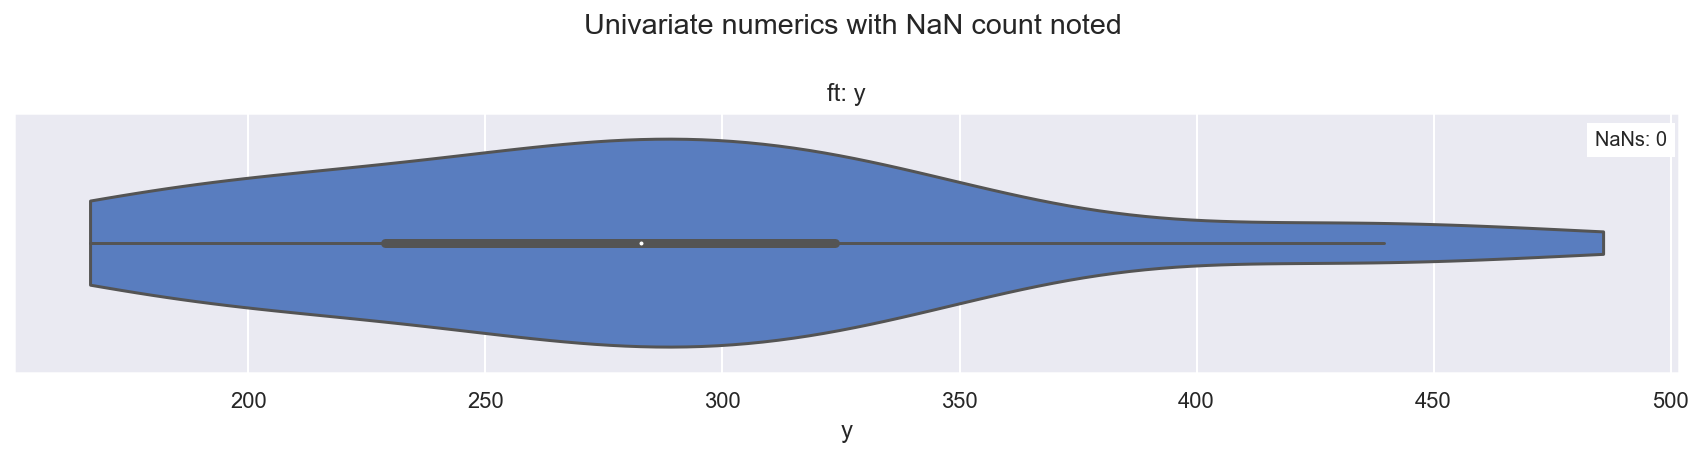

In [7]:
def plot_univariate_violin(df: pd.DataFrame, fts: list):
    v_kws = dict(data=df, cut=0)
    cs = sns.color_palette(n_colors=len(fts))
    height_bump = 2 if len(fts) == 1 else 1
    f, axs = plt.subplots(
        len(fts), 1, figsize=(12, 0.8 + height_bump * 1.2 * len(fts)), squeeze=False, sharex=True
    )
    for i, ft in enumerate(fts):
        ax = sns.violinplot(x=ft, **v_kws, ax=axs[i][0], color=cs[i])
        n_nans = pd.isnull(df[ft]).sum()
        _ = ax.text(
            0.993,
            0.93,
            f"NaNs: {n_nans}",
            transform=ax.transAxes,
            ha="right",
            va="top",
            backgroundcolor="w",
            fontsize=10,
        )
        _ = ax.set_title(f"ft: {ft}")
    _ = f.suptitle("Univariate numerics with NaN count noted")
    _ = f.tight_layout()


plot_univariate_violin(df, fts=["y"])

**Observe:**

+ `y` Looks smooth, reasonably central, can probably model with a Normal likelihood

### 0.2.2 Univariate: predictors `a, b, c, d`

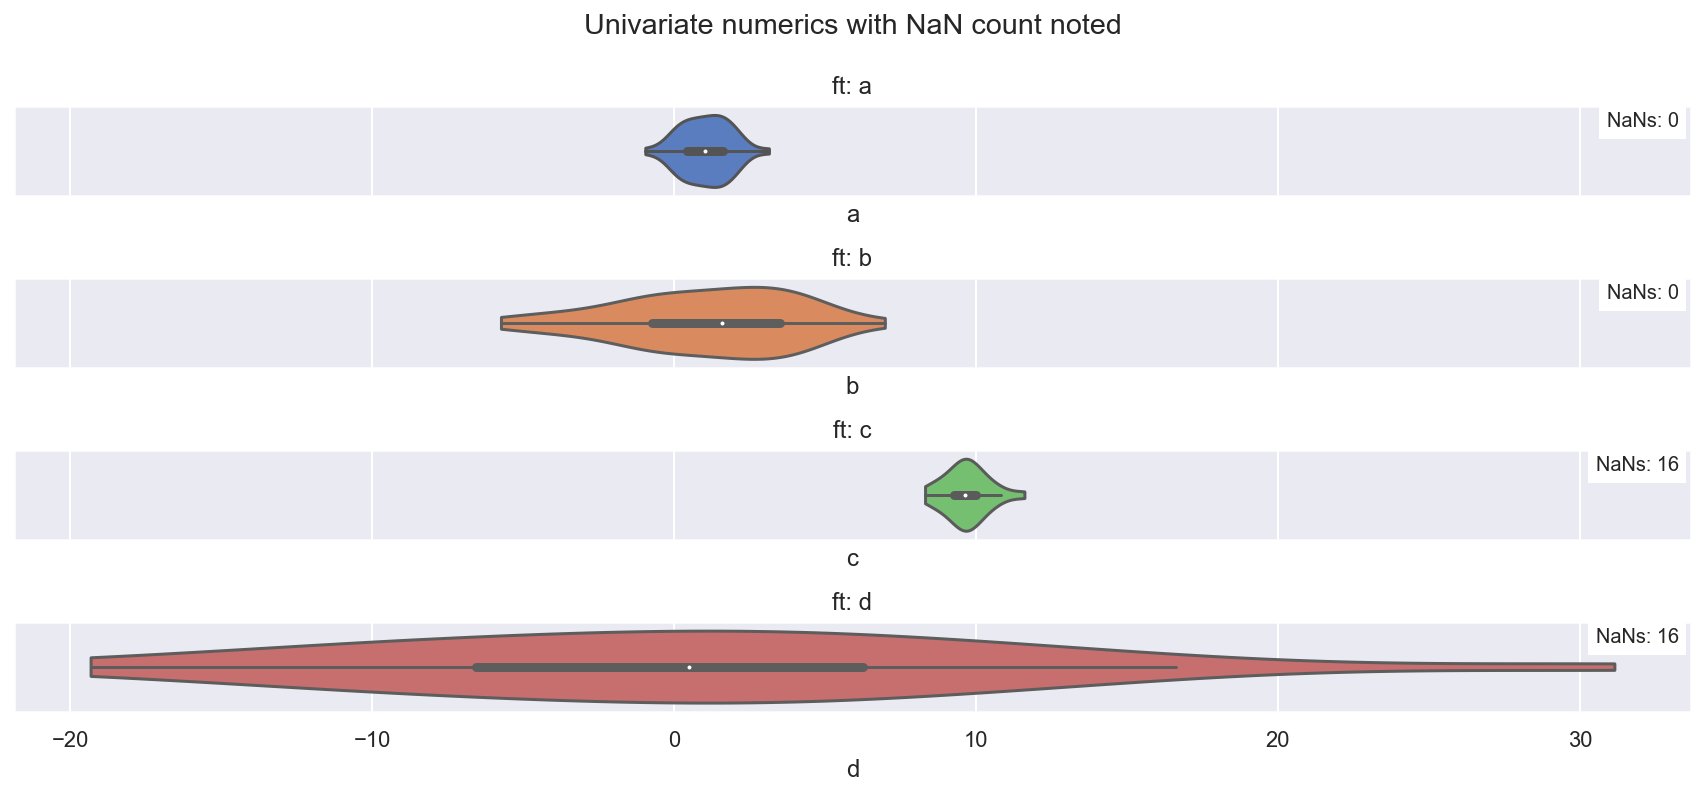

In [8]:
plot_univariate_violin(df, fts=["a", "b", "c", "d"])

**Observe:**

+ `a`, `b`, `c`, `d` Vary across the range, but all reasonably central, can probably model with Normal distributions
+ `c`, `d` each contain `16` NaN values

### 0.2.3 Bivariate: target vs predictors

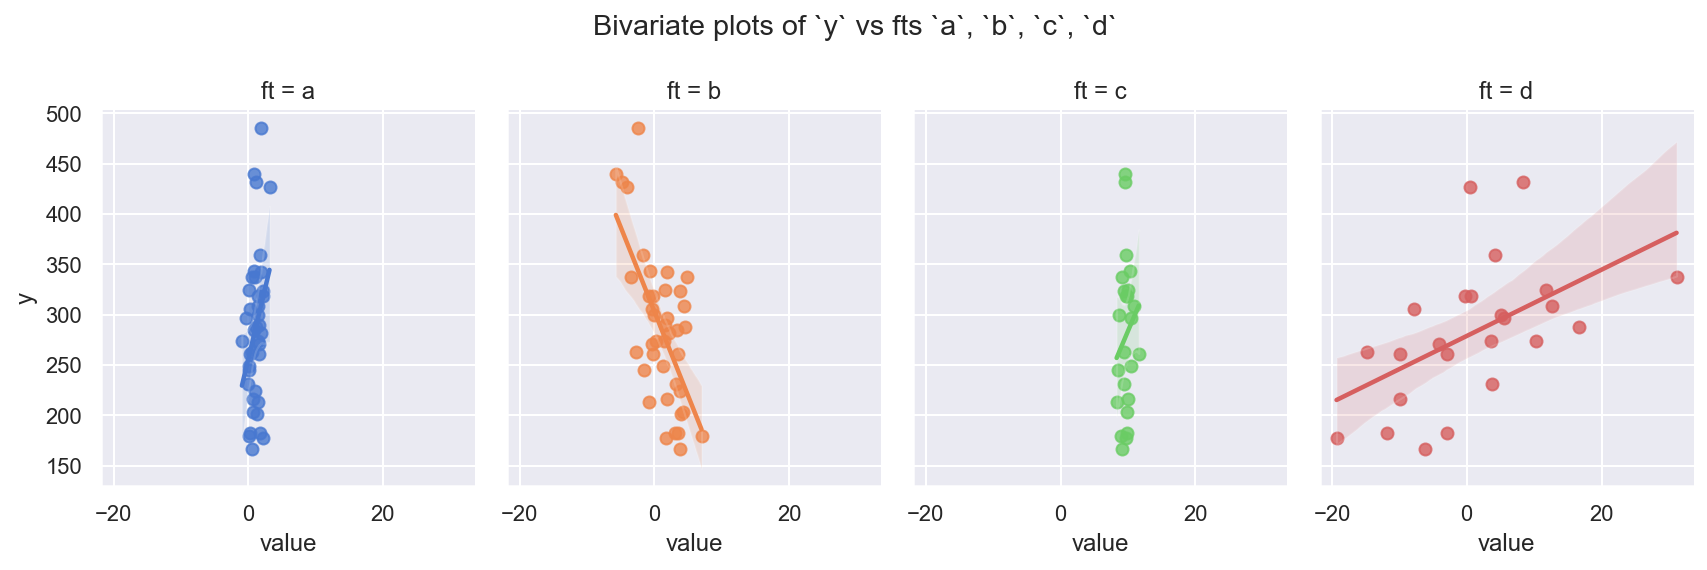

In [9]:
dfp = df.reset_index().melt(id_vars=["oid", "y"], var_name="ft")
g = sns.lmplot(
    y="y",
    x="value",
    hue="ft",
    col="ft",
    data=dfp,
    fit_reg=True,
    height=4,
    aspect=0.75,
)
_ = g.fig.suptitle("Bivariate plots of `y` vs fts `a`, `b`, `c`, `d`")
_ = g.fig.tight_layout()

**Observe:**

+ Each of features `a`, `b`, `c`, `d` has a correlation to `y`, some stronger, some weaker
+ This looks fairly realistic

## 0.3 Transform dataset to `dfx` for model input

**IMPORTANT NOTE**

+ Reminder that Bayesian inferential methods **do not need** a `test` dataset (nor k-fold cross validation)
  to fit parameters. 
+ We also **do not need** a `holdout` (out-of-sample) dataset (that contains target `y` values) to evaluate model
  performance, because we can use in-sample PPC, LOO-PIT and ELPD evaluations
+ Depending on the real-world model implementation we might:
  + Create a separate `holdout` set (even though we dont need it) to simply eyeball the behaviour of predictive outputs
  + Create a `forecast` set (which does not have target `y` values) to demonstrate how we would use the model and it's
    predictive outputs on future new data in Production
+ Here we **do** take a `holdout` set, in order to eyeball the predictive outputs, and also to eyeball the auto-imputed
  missing values compared to the true synthetic data. This is only possible because we synthesized the true data above.
+ Per the following terminology, `df` created above is our "working" dataset, which we will partition into "train" and 
  "holdout"

**Dataset terminology / partitioning / purpose:**

```text
|<---------- Relevant domain of all data for our analyses & models ---------->|
|<----- "Observed" historical target ------>||<- "Unobserved" future target ->|
|<----------- "Working" dataset ----------->||<----- "Forecast" dataset ----->|
|<- Training/CrossVal ->||<- Test/Holdout ->|
```

### 0.3.1 Separate `df_train` and `df_holdout`

**NOTE**

+ We have full control over how many observations we create in `df`, so the ratio of this split doesn't really matter,
  and we'll arrange to have `10` observations in the holdout set
+ Eyeball the `count` of non-nulls in the below tabels to ensure we have missing values in both features `c`, `d` in 
  both datasets `train` and `holdout`

In [10]:
df_train = df.sample(n=len(df) - 10, replace=False).sort_index()
print(df_train.shape)
display(
    pd.concat(
        (df_train.describe(include="all").T, df_train.isnull().sum(), df_train.dtypes), axis=1
    )
)

(30, 5)


,count,mean,std,min,25%,50%,75%,max,0,1
a,30.0,1.003345,0.819294,-0.951035,0.508736,1.024615,1.458337,3.141648,0,float64
b,30.0,1.325699,2.952791,-4.828623,-0.735780,1.642586,3.668029,6.979765,0,float64
c,17.0,9.491124,0.668245,8.312666,9.066382,9.576702,9.901515,10.840308,13,float64
d,18.0,1.979464,12.358710,-19.320463,-5.627300,2.081288,9.851212,31.138625,12,float64
y,30.0,274.032265,79.378533,166.591767,213.717853,271.797565,315.813022,485.762125,0,float64


In [11]:
df_holdout = df.loc[list(set(df.index.values) - set(df_train.index.values))].copy().sort_index()
print(df_holdout.shape)
display(
    pd.concat(
        (df_holdout.describe(include="all").T, df_holdout.isnull().sum(), df_holdout.dtypes), axis=1
    )
)

(10, 5)


,count,mean,std,min,25%,50%,75%,max,0,1
a,10.0,1.143026,0.881081,-0.302180,0.443087,1.268323,1.847161,2.128972,0,float64
b,10.0,0.233740,2.796858,-5.731479,-0.616643,-0.258036,2.086047,3.761941,0,float64
c,7.0,10.138714,0.739799,9.470507,9.629392,9.920282,10.359824,11.601779,3,float64
d,6.0,-1.865221,6.263092,-9.849438,-6.669775,-1.607591,3.094418,5.568711,4,float64
y,10.0,318.907654,53.307791,260.662351,285.368757,311.909327,338.300528,439.462555,0,float64


### 0.3.2 Create `dfx_train`

Transform (zscore and scale) numerics

In [12]:
FTS_NUM = ["a", "b", "c", "d"]
FTS_NON_NUM = []
FTS_Y = ["y"]
MNS = np.nanmean(df_train[FTS_NUM], axis=0)
SDEVS = np.nanstd(df_train[FTS_NUM], axis=0)

dfx_train_num = (df_train[FTS_NUM] - MNS) / SDEVS
icpt = pd.Series(np.ones(len(df_train)), name="intercept", index=dfx_train_num.index)

# concat including y which will be used as observed
dfx_train = pd.concat((df_train[FTS_Y], icpt, df_train[FTS_NON_NUM], dfx_train_num), axis=1)
display(dfx_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
y,30.0,2.740323e+02,79.378533,166.591767,213.717853,271.797565,315.813022,485.762125
intercept,30.0,1.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a,30.0,0.000000e+00,1.017095,-2.426225,-0.614022,0.026405,0.564841,2.654552
b,30.0,8.557969e-17,1.017095,-2.119870,-0.710081,0.109152,0.806821,1.947556
c,17.0,-3.200055e-16,1.030776,-1.817787,-0.655169,0.132005,0.633033,2.081135
d,18.0,1.233581e-17,1.028992,-1.773441,-0.633342,0.008478,0.655405,2.427804


### 0.3.3 Create `dfx_holdout`

In [13]:
dfx_holdout_num = (df_holdout[FTS_NUM] - MNS) / SDEVS
icpt = pd.Series(np.ones(len(df_holdout)), name="intercept", index=dfx_holdout_num.index)

# concat including y which will be used as observed
dfx_holdout = pd.concat((df_holdout[FTS_Y], icpt, df_holdout[FTS_NON_NUM], dfx_holdout_num), axis=1)
display(dfx_holdout.describe().T)

,count,mean,std,min,25%,50%,75%,max
y,10.0,318.907654,53.307791,260.662351,285.368757,311.909327,338.300528,439.462555
intercept,10.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a,10.0,0.173404,1.093801,-1.620716,-0.695520,0.328951,1.047539,1.397387
b,10.0,-0.376128,0.963384,-2.430861,-0.669044,-0.545521,0.261903,0.839169
c,7.0,0.998917,1.141150,-0.031801,0.213281,0.661982,1.339982,3.255714
d,6.0,-0.320110,0.521468,-0.984879,-0.720139,-0.298660,0.092832,0.298842


---

---

# 1. Model 0: Synthetic Data Without Missing Values, Set a Baseline for Comparison

This section might seem unusual or unnecessary, but will hopefully provide a useful comparison for general behaviour
and help to further explain the model architecture used in `Model A`. 

We will create `Model 0` using the same general linear model, operating on the `dfrawx_train` dataset _without_ any
missing values:

$$
\begin{align}
\sigma_{\beta} &\sim \text{InverseGamma}(11, 10)  \\
\beta_{j} &\sim \text{Normal}(0, \sigma_{\beta}, \text{shape}=j)  \\
\\
\epsilon &\sim \text{InverseGamma}(11, 10)  \\
\hat{y_{i}} &\sim \text{Normal}(\mu=\beta_{j}^{T}\mathbb{x}_{ij}, \sigma=\epsilon)  \\
\end{align}
$$

where:
+ Observations $i$ contain numeric features $j$ that have complete values (this is all features `a`, `b`, `c`, `d`)
+ Our target is $\hat{y_{i}}$, here of `y` with linear sub-model $\beta_{j}^{T}\mathbb{x}_{ij}$ 
  to regress onto those features

## 1.0 Quickly prepare non-missing datasets based on `dfraw`

This is a lightly simplifed copy of the same logic / workflow in $\S0.3$ above. We won't take up any more space here 
with EDA, the only difference is `c` and `d` are now complete

Partition `dfraw` into `dfraw_train` and `dfraw_holdout`, use same indexes as `df_train` and `df_holdout`

In [14]:
dfraw_train = dfraw.loc[df_train.index].copy()
dfraw_holdout = dfraw.loc[df_holdout.index].copy()
dfraw_holdout.tail()

,a,b,c,d,y
oid,,,,,
o21,0.319070,-0.339540,11.299228,-7.895381,305.700832
o35,2.128972,3.761941,9.470507,19.679299,323.667882
o36,0.886053,-0.709011,10.232676,3.302745,343.178076
o38,0.175519,3.502362,11.601779,-2.992956,260.791421
o39,1.650593,-0.237386,9.760644,-9.849438,260.662351


Create `dfrawx_train`: Transform (zscore and scale) numerics

In [15]:
MNS_RAW = np.nanmean(dfraw_train[FTS_NUM], axis=0)
SDEVS_RAW = np.nanstd(dfraw_train[FTS_NUM], axis=0)

dfrawx_train_num = (dfraw_train[FTS_NUM] - MNS_RAW) / SDEVS_RAW
icpt = pd.Series(np.ones(len(dfraw_train)), name="intercept", index=dfrawx_train_num.index)

# concat including y which will be used as observed
dfrawx_train = pd.concat(
    (dfraw_train[FTS_Y], icpt, dfraw_train[FTS_NON_NUM], dfrawx_train_num), axis=1
)
display(dfrawx_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
y,30.0,2.740323e+02,79.378533,166.591767,213.717853,271.797565,315.813022,485.762125
intercept,30.0,1.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a,30.0,0.000000e+00,1.017095,-2.426225,-0.614022,0.026405,0.564841,2.654552
b,30.0,8.557969e-17,1.017095,-2.119870,-0.710081,0.109152,0.806821,1.947556
c,30.0,-2.157533e-15,1.017095,-1.822392,-0.749483,0.042663,0.818903,1.703118
d,30.0,7.401487e-18,1.017095,-1.802804,-0.806341,-0.068115,0.749934,2.612742


Create `dfrawx_holdout`

In [16]:
dfrawx_holdout_num = (dfraw_holdout[FTS_NUM] - MNS_RAW) / SDEVS_RAW
icpt = pd.Series(np.ones(len(dfraw_holdout)), name="intercept", index=dfrawx_holdout_num.index)

# concat including y which will be used as observed
dfrawx_holdout = pd.concat(
    (dfraw_holdout[FTS_Y], icpt, dfraw_holdout[FTS_NON_NUM], dfrawx_holdout_num), axis=1
)
display(dfrawx_holdout.describe().T)

,count,mean,std,min,25%,50%,75%,max
y,10.0,318.907654,53.307791,260.662351,285.368757,311.909327,338.300528,439.462555
intercept,10.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a,10.0,0.173404,1.093801,-1.620716,-0.695520,0.328951,1.047539,1.397387
b,10.0,-0.376128,0.963384,-2.430861,-0.669044,-0.545521,0.261903,0.839169
c,10.0,0.919537,1.011017,-0.177702,0.093290,0.654334,1.401695,2.748664
d,10.0,0.028213,0.732618,-0.974019,-0.350074,0.022664,0.345240,1.609965


Note the inevitable (but slight) difference in `MNS` vs `MNS_RAW` and `SDEVS` vs `SDEVS_RAW`

In [17]:
print(MNS)
print(MNS_RAW)
print(SDEVS)
print(SDEVS_RAW)

[1.00334482 1.32569933 9.4911236  1.9794641 ]
[1.00334482 1.32569933 9.59992738 1.28126266]
[ 0.805523    2.90316032  0.64829269 12.01050744]
[ 0.805523    2.90316032  0.72829993 11.42759827]


## 1.1 Build Model Object

In [18]:
ft_y = "y"
FTS_XJ = ["intercept", "a", "b", "c", "d"]

COORDS = dict(xj_nm=FTS_XJ, oid=dfrawx_train.index.values)

with pm.Model(coords=COORDS) as mdl0:
    # 0. create (Mutable)Data containers for obs (Y, X)
    y = pm.Data("y", dfrawx_train[ft_y].values, dims="oid")  # (i, )
    xj = pm.Data("xj", dfrawx_train[FTS_XJ].values, dims=("oid", "xj_nm"))  # (i, xj)

    # 2. define priors for contiguous data
    b_s = pm.Gamma("beta_sigma", alpha=10, beta=10)  # E ~ 1
    bj = pm.Normal("beta_j", mu=0, sigma=b_s, dims="xj_nm")

    # 4. define evidence
    epsilon = pm.Gamma("epsilon", alpha=50, beta=50)  # encourage E ~ 1
    lm = pt.dot(xj, bj.T)
    _ = pm.Normal("yhat", mu=lm, sigma=epsilon, observed=y, dims="oid")

RVS_PPC = ["yhat"]
RVS_PRIOR = ["epsilon", "beta_sigma", "beta_j"]

##### Verify the built model structure matches our intent, and validate the parameterization

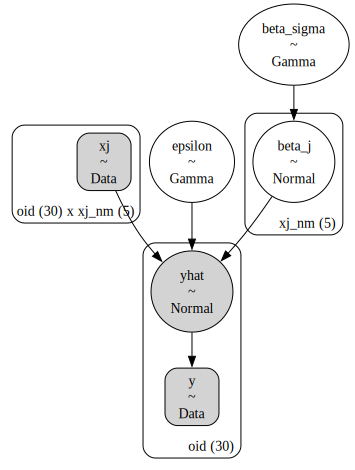

{'unobserved': [beta_sigma ~ Gamma(10, f()),
  beta_j ~ Normal(0, beta_sigma),
  epsilon ~ Gamma(50, f())],
 'observed': [yhat ~ Normal(f(beta_j), epsilon)]}

point={'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [19]:
display(pm.model_to_graphviz(mdl0, formatting="plain"))
display(dict(unobserved=mdl0.unobserved_RVs, observed=mdl0.observed_RVs))
assert_no_rvs(mdl0.logp())
mdl0.debug(fn="logp", verbose=True)
mdl0.debug(fn="random", verbose=True)

**Observe:**

+ This is a very straightforward model

## 1.2 Sample Prior Predictive, View Diagnostics

In [20]:
kws = dict(samples=2000, return_inferencedata=True, random_seed=42)
with mdl0:
    id0 = pm.sample_prior_predictive(var_names=RVS_PPC + RVS_PRIOR, **kws)

Sampling: [beta_j, beta_sigma, epsilon, yhat]


### 1.2.1 In-Sample Prior PPC (Retrodictive Check)

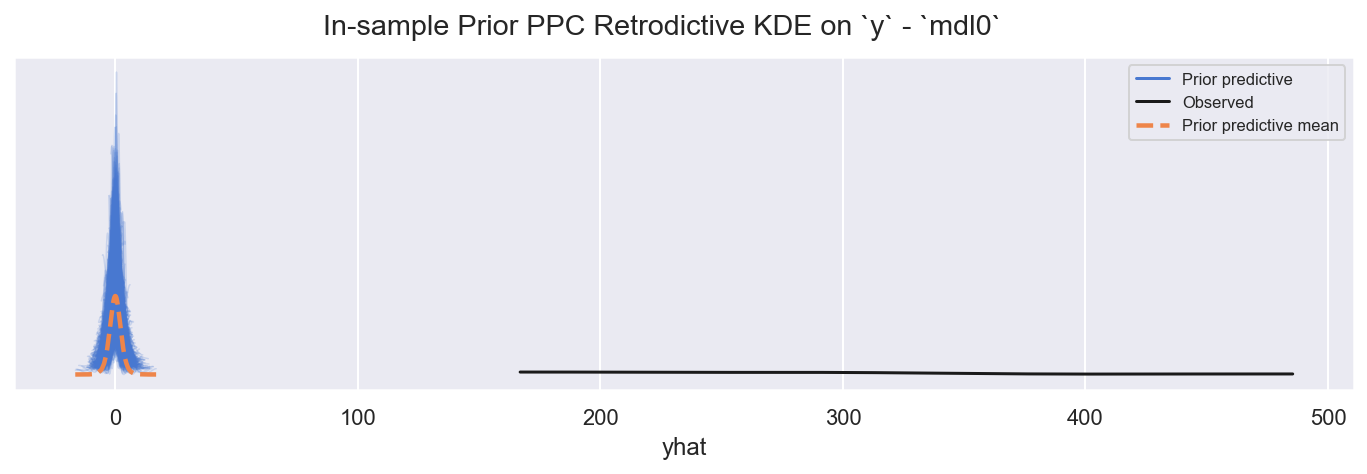

In [21]:
def plot_ppc_retrodictive(
    idata: az.InferenceData,
    grp: str = "posterior",
    rvs: list = None,
    mdlnm: str = "mdla",
    ynm: str = "y",
) -> plt.Figure:
    """Convenience plot prior or posterior PPC retrodictive KDE"""
    f, axs = plt.subplots(1, 1, figsize=(12, 3))
    _ = az.plot_ppc(idata, group=grp, kind="kde", var_names=rvs, ax=axs, observed=True)
    _ = f.suptitle(f"In-sample {grp.title()} PPC Retrodictive KDE on `{ynm}` - `{mdlnm}`")
    return f


f = plot_ppc_retrodictive(id0, grp="prior", rvs=["yhat"], mdlnm="mdl0", ynm="y")

**Observe:**

+ The prior PPC is wrong as expected, because we've set relatively uninformative priors
+ However the general range and scale is reasonable and the sampler should be able to 
  find the highest likelihood latent space easily

### 1.2.2 Quick look at selected priors

#### Coefficients etc

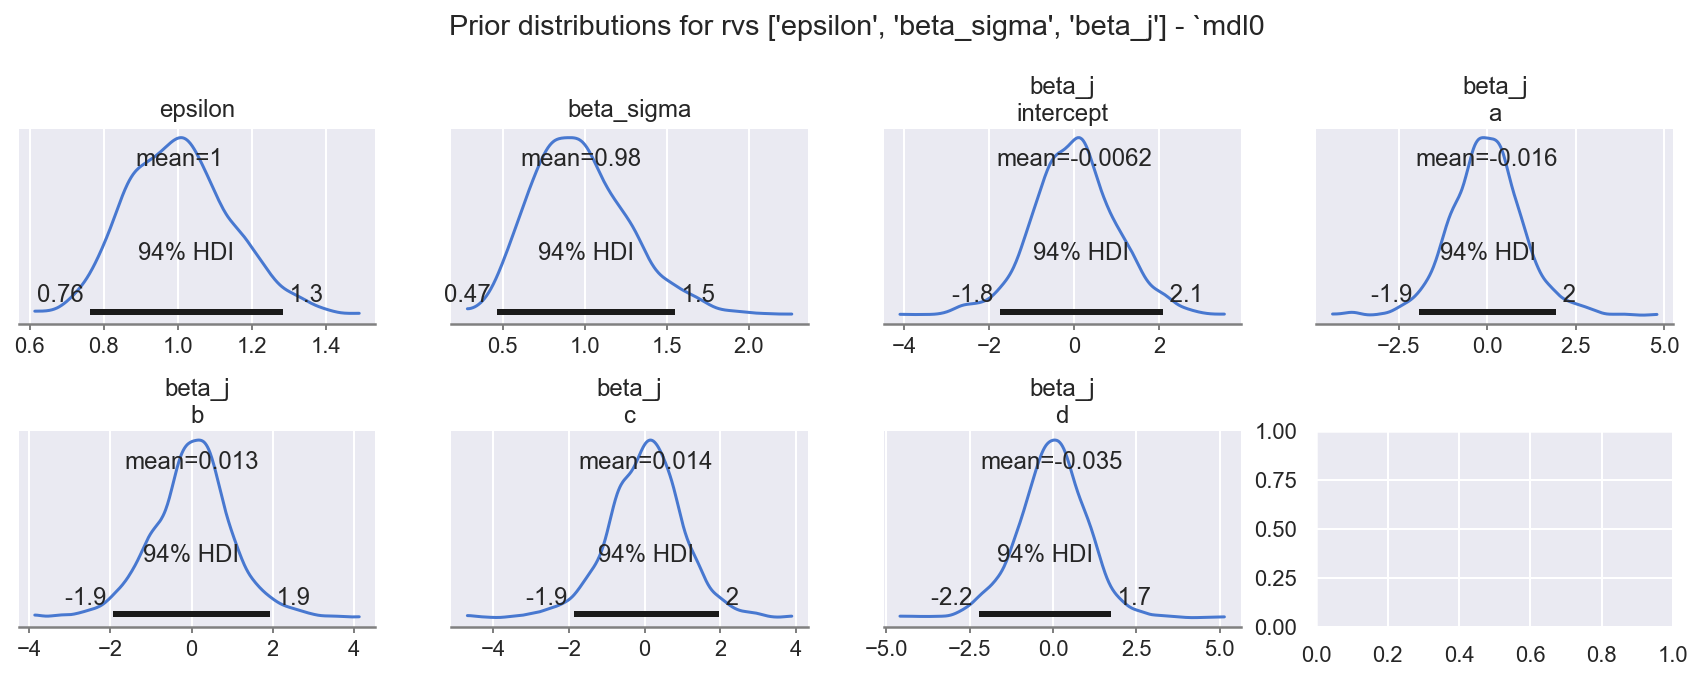

In [22]:
def plot_krushke(
    idata: az.InferenceData,
    group: str = "posterior",
    rvs: list = RVS_PRIOR,
    coords: dict = None,
    ref_vals: list = None,
    mdlnm: str = "mdla",
    n: int = 1,
    nrows: int = 1,
) -> plt.figure:
    """Convenience plot Krushke-style posterior (or prior) KDE"""
    m = int(np.ceil(n / nrows))
    f, axs = plt.subplots(nrows, m, figsize=(3 * m, 0.8 + nrows * 2))
    _ = az.plot_posterior(
        idata, group=group, ax=axs, var_names=rvs, coords=coords, ref_val=ref_vals
    )
    _ = f.suptitle(f"{group.title()} distributions for rvs {rvs} - `{mdlnm}")
    _ = f.tight_layout()
    return f


f = plot_krushke(id0, "prior", rvs=RVS_PRIOR, mdlnm="mdl0", n=1 + 1 + 5, nrows=2)

**Observe:**

+ Model priors `beta_sigma`, `beta_j: (levels)`, `epsilon` all have reasonable prior ranges as specified

## 1.3 Sample Posterior, View Diagnostics

### 1.3.1 Sample Posterior and PPC

In [23]:
with mdl0:
    id0.extend(pm.sample(**SAMPLE_KWS), join="right")
    id0.extend(
        pm.sample_posterior_predictive(trace=id0.posterior, var_names=RVS_PPC),
        join="right",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_sigma, beta_j, epsilon]


Output()

Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 2 seconds.
Sampling: [yhat]


Output()

### 1.3.2 View Traces

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.987,0.102,0.799,1.173,0.002,0.002,2005.0,1378.0,1.0
beta_sigma,20.353,0.834,18.902,21.955,0.016,0.011,2741.0,1206.0,1.0
beta_j[intercept],274.014,0.179,273.689,274.364,0.004,0.003,2129.0,1329.0,1.0
beta_j[a],8.090,0.199,7.673,8.421,0.005,0.003,1774.0,1415.0,1.0
beta_j[b],-58.008,0.198,-58.402,-57.663,0.005,0.004,1603.0,1380.0,1.0
beta_j[c],21.601,0.192,21.238,21.948,0.004,0.003,2100.0,1562.0,1.0
beta_j[d],57.194,0.180,56.855,57.543,0.004,0.003,2213.0,1740.0,1.0


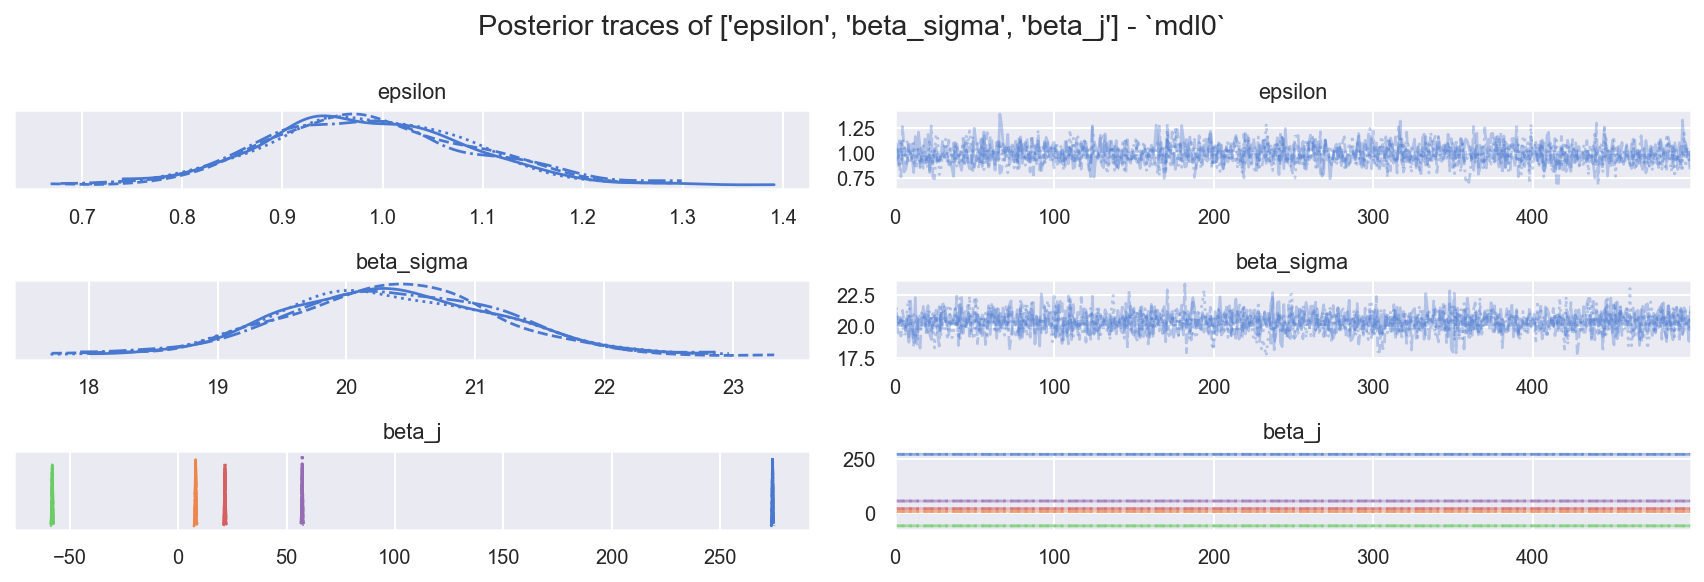

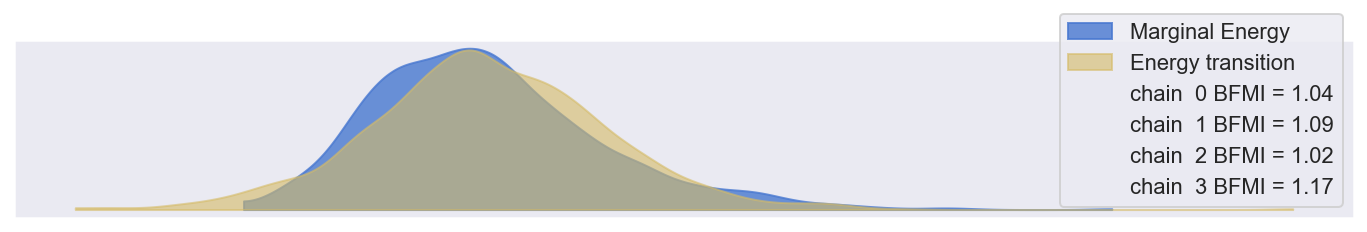

In [24]:
def plot_traces_and_display_summary(
    idata: az.InferenceData, rvs: list = None, coords: dict = None, mdlnm="mdla", energy=False
) -> plt.Figure:
    """Convenience to plot traces and display summary table for rvs"""
    _ = az.plot_trace(idata, var_names=rvs, coords=coords, figsize=(12, 0.8 + 1.1 * len(rvs)))
    f = plt.gcf()
    _ = f.suptitle(f"Posterior traces of {rvs} - `{mdlnm}`")
    _ = f.tight_layout()
    if energy:
        _ = az.plot_energy(idata, fill_alpha=(0.8, 0.6), fill_color=("C0", "C8"), figsize=(12, 1.6))
    display(az.summary(idata, var_names=rvs))
    return f


f = plot_traces_and_display_summary(id0, rvs=RVS_PRIOR, mdlnm="mdl0", energy=True)

**Observe:**

+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks a little mismatched, but `E-BFMI > 0.3` so is
  [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

### 1.3.3 In-Sample Posterior PPC (Retrodictive Check)

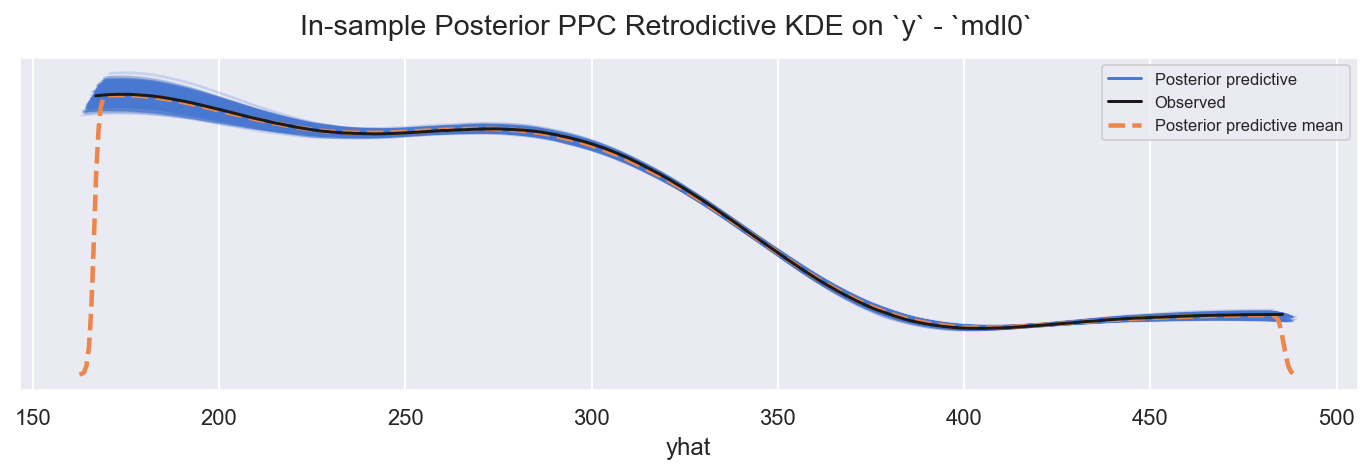

In [25]:
f = plot_ppc_retrodictive(id0, grp="posterior", rvs=["yhat"], mdlnm="mdl0", ynm="y")

**Observe:**

+ In-sample PPC `yhat` tracks the observed `y` very closely

### 1.3.4 In-Sample PPC LOO-PIT

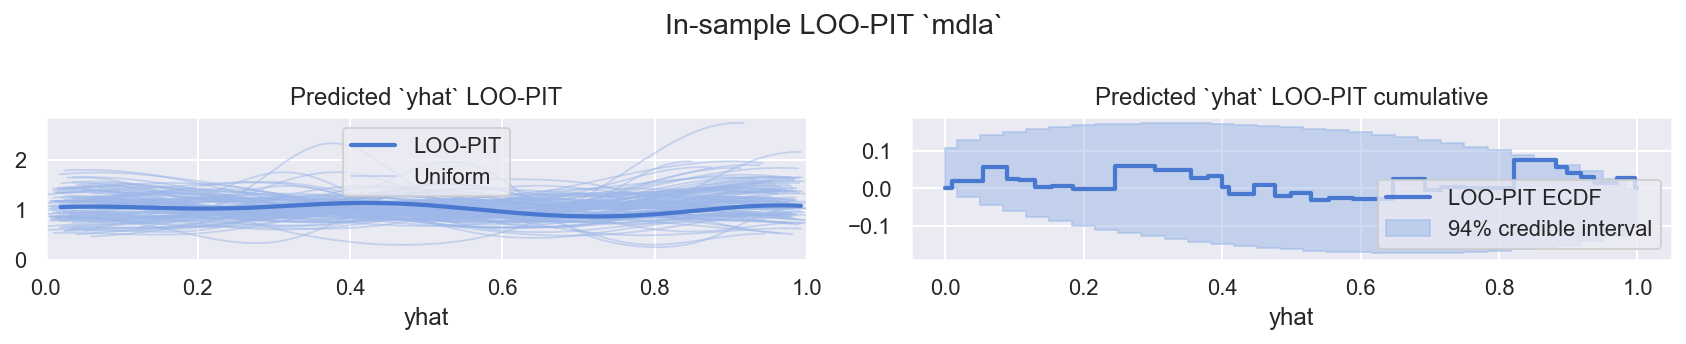

In [26]:
def plot_loo_pit(
    idata: az.InferenceData, mdlname: str = "mdla", y: str = "yhat", y_hat: str = "yhat"
) -> plt.Figure:
    """Convenience plot LOO-PIT KDE and ECDF"""
    f, axs = plt.subplots(1, 2, figsize=(12, 2.4))
    _ = az.plot_loo_pit(idata, y=y, y_hat=y_hat, ax=axs[0])
    _ = az.plot_loo_pit(idata, y=y, y_hat=y_hat, ax=axs[1], ecdf=True)
    _ = axs[0].set_title(f"Predicted `{y_hat}` LOO-PIT")
    _ = axs[1].set_title(f"Predicted `{y_hat}` LOO-PIT cumulative")
    _ = f.suptitle(f"In-sample LOO-PIT `{mdlname}`")
    _ = f.tight_layout()
    return f


f = plot_loo_pit(id0, "mdla")

**Observe:**

+ `LOO-PIT` looks good, very slightly overdispersed but more than acceptable for use

## 1.4 Evaluate Posterior Parameters

### 1.4.1 Coefficients etc

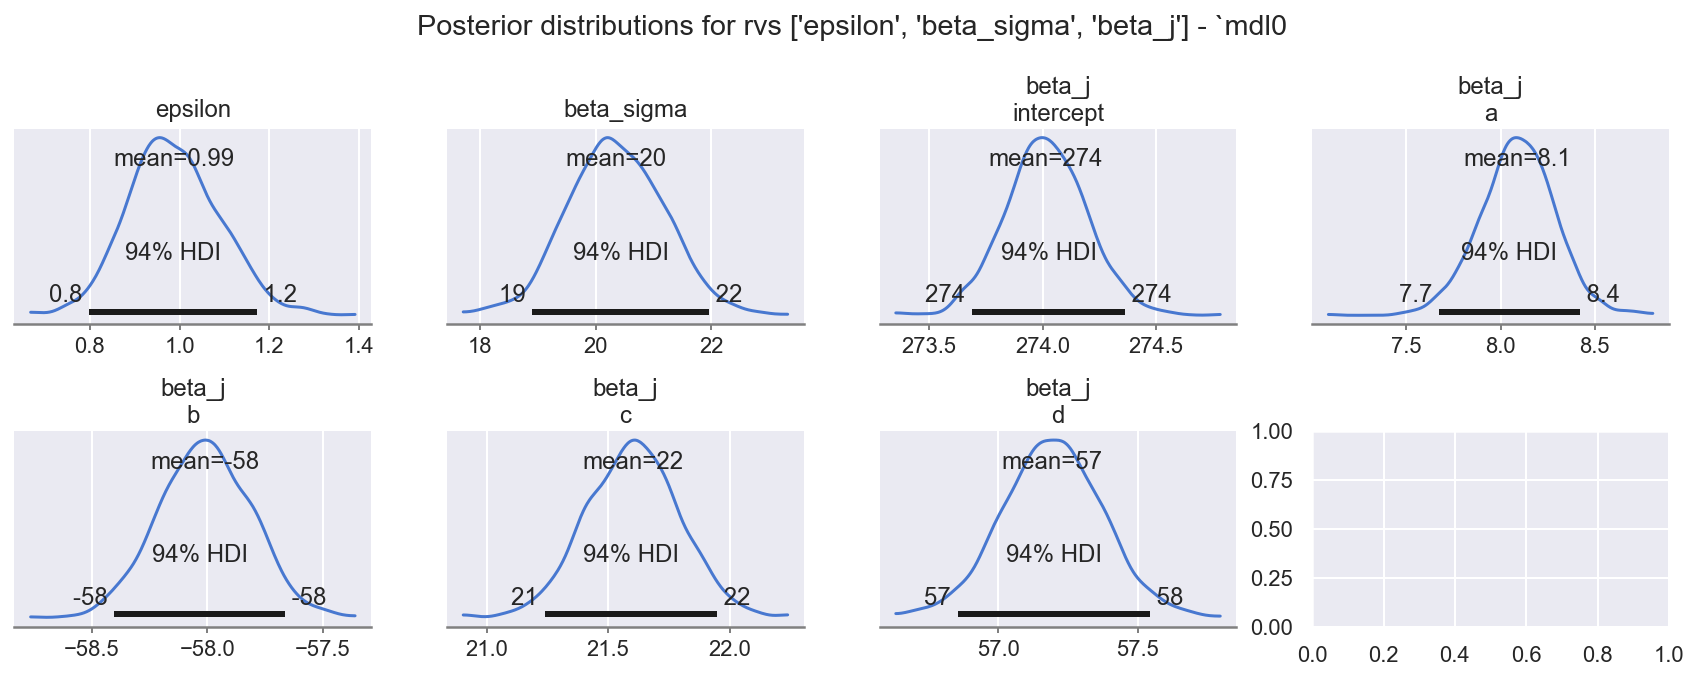

In [27]:
f = plot_krushke(id0, "posterior", RVS_PRIOR, mdlnm="mdl0", n=1 + 1 + 5, nrows=2)

**Observe:**

+ Posteriors for model coeffs `beta_sigma`, `beta_j: (levels)`, `epsilon` all smooth and central as specified

#### For interest's sake forestplot the `beta_j` levels to compare relative effects

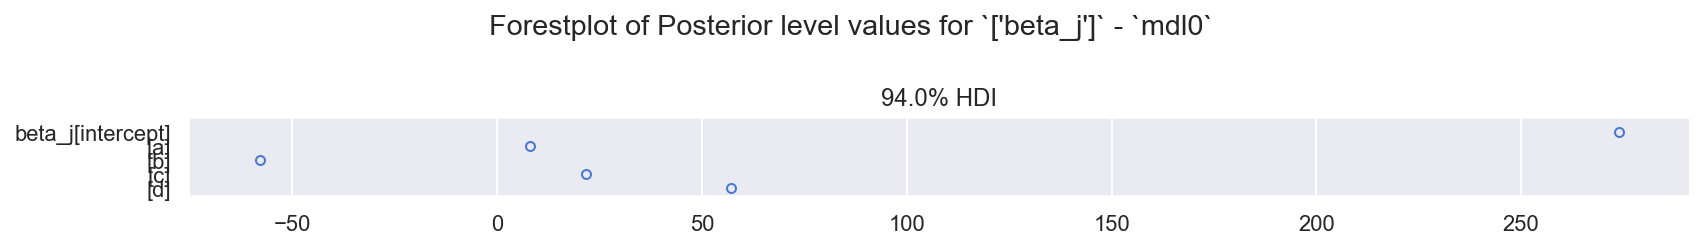

In [28]:
def plot_forest(
    idata: az.InferenceData, grp: str = "posterior", rvs: list = None, mdlnm="mdla"
) -> plt.Figure:
    """Convenience forestplot posterior (or prior) KDE"""

    n = sum([idata[grp][rv].shape[-1] for rv in rvs])
    f, axs = plt.subplots(1, 1, figsize=(12, 0.5 + 0.25 * n))
    _ = az.plot_forest(idata[grp], var_names=rvs, ax=axs, combined=True)
    _ = f.suptitle(f"Forestplot of {grp.title()} level values for `{rvs}` - `{mdlnm}`")
    _ = f.tight_layout()
    return f


f = plot_forest(id0, grp="posterior", rvs=["beta_j"], mdlnm="mdl0")

**Observe:**

+ Very tight and distinct posterior distributions

## 1.5 Create PPC Forecast on `dfrawx_holdout` set

### 1.5.1 Replace dataset with `dfrawx_holdout`

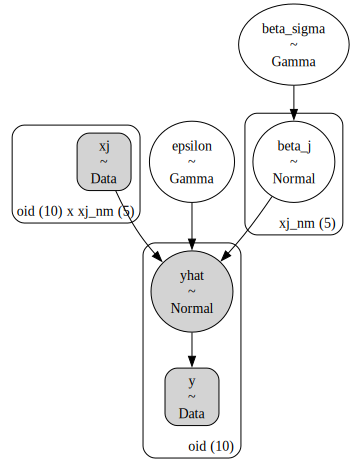

point={'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

The variable yhat has the following parameters:
0: CGemv{no_inplace} [id A] <Vector(float64, shape=(?,))>
 ├─ AllocEmpty{dtype='float64'} [id B] <Vector(float64, shape=(?,))>
 │  └─ Shape_i{0} [id C] <Scalar(int64, shape=())>
 │     └─ xj [id D] <Matrix(float64, shape=(?, ?))>
 ├─ 1.0 [id E] <Scalar(float64, shape=())>
 ├─ xj [id D] <Matrix(float64, shape=(?, ?))>
 ├─ beta_j [id F] <Vector(float64, shape=(?,))>
 └─ 0.0 [id G] <Scalar(float64, shape=())>
1: Exp [id H] <Vector(float64, shape=(1,))>
 └─ ExpandDims{axis=0} [id I] <Vector(float64, shape=(1,))>
    └─ epsilon_log__ [id J] <Scalar(float64, shape=())>
The parameters evaluate to:
0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1: [1.]
The variable yhat logp method raised the following exception: Shape mismatch: A.shape[0] != y.shape[0]

Shape mismatch: A.shape[0] != y.shape[0]
Apply node that caused the error: CGemv{no_inplace}(y, -1.0,

In [29]:
COORDS_F = deepcopy(COORDS)
COORDS_F["oid"] = dfrawx_holdout.index.values
mdl0.set_data("xj", dfrawx_holdout[FTS_XJ].values, coords=COORDS_F)

display(pm.model_to_graphviz(mdl0, formatting="plain"))
assert_no_rvs(mdl0.logp())
mdl0.debug(fn="logp", verbose=True)
mdl0.debug(fn="random", verbose=True)

### 1.5.2 Sample PPC for `yhat`

In [30]:
with mdl0:
    id0_h = pm.sample_posterior_predictive(trace=id0.posterior, var_names=RVS_PPC, predictions=True)

Sampling: [yhat]


Output()

### 1.5.3 Out-of-sample: Compare forecasted `yhat` to known true value `y`

##### Extract `yhat` from PPC idata, and attach real values (only available because it's a `holdout` set)

In [31]:
dfraw_h_y = (
    az.extract(id0_h, group="predictions", var_names=["yhat"])
    .to_dataframe()
    .drop(["chain", "draw"], axis=1)
    .reset_index()
    .set_index(["oid"])
)
dfraw_h_y = pd.merge(dfraw_h_y, dfraw_holdout[["y"]], how="left", left_index=True, right_index=True)
dfraw_h_y.describe().T

,count,mean,std,min,25%,50%,75%,max
chain,20000.0,1.500000,1.118062,0.000000,0.750000,1.500000,2.250000,3.000000
draw,20000.0,249.500000,144.340887,0.000000,124.750000,249.500000,374.250000,499.000000
yhat,20000.0,318.723908,50.103892,256.275207,281.913031,312.293786,342.391247,441.775946
y,20000.0,318.907654,50.573475,260.662351,281.480703,311.909327,343.178076,439.462555


##### Plot posterior `yhat` vs known true values `y` (only available because it's a `holdout` set)

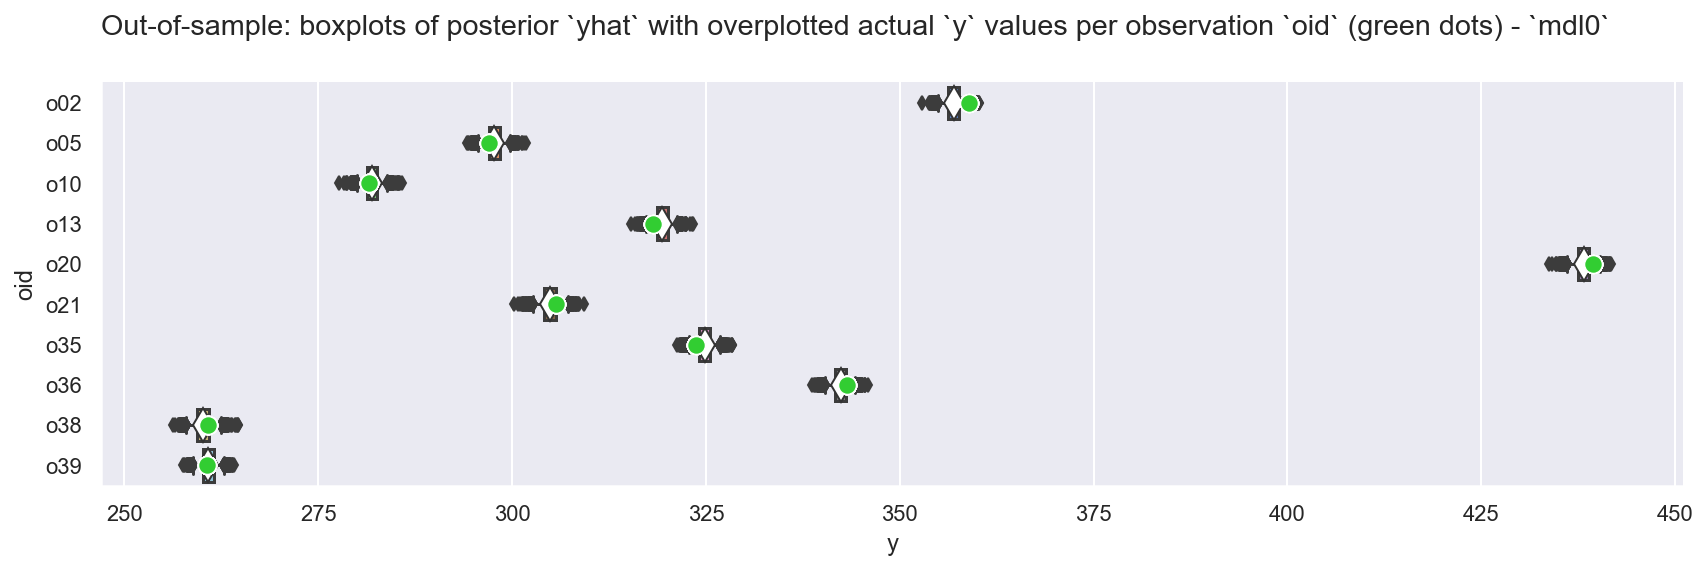

In [32]:
def plot_yhat_vs_y(
    df_h: pd.DataFrame, yhat: str = "yhat", y: str = "y", mdlnm: str = "mdla"
) -> plt.Figure:
    """Convenience plot forecast yhat with overplotted y from holdout set"""
    g = sns.catplot(x=yhat, y="oid", data=df_h.reset_index(), **KWS_BOX, height=4, aspect=3)
    _ = g.map(sns.scatterplot, y, "oid", **KWS_SCTR, zorder=100)
    _ = g.fig.suptitle(
        f"Out-of-sample: boxplots of posterior `{yhat}` with overplotted actual `{y}` values"
        + f" per observation `oid` (green dots) - `{mdlnm}`"
    )
    _ = g.tight_layout()
    return g.fig


_ = plot_yhat_vs_y(dfraw_h_y, mdlnm="mdl0")

**Observe:**

+ The predictions `yhat` look pretty close to the true value `y`, usually well within the HDI94 and HDI50
+ As we would expect, the distributions of `yhat` are useful too: quantifing the uncertainty in prediction and letting us
  make better decisions accordingly.

---

---

# 2. Model A: Auto-impute Missing Values, use Masked Array

Now we progress to handling missing values!

This is a simple linear model with a hierarchical prior on the data for features $k$ that have missing values:

$$
\begin{align}
\sigma_{\beta} &\sim \text{InverseGamma}(11, 10)  \\
\beta_{j} &\sim \text{Normal}(0, \sigma_{\beta}, \text{shape}=j)  \\
\beta_{k} &\sim \text{Normal}(0, \sigma_{\beta}, \text{shape}=k)  \\
\\
\mu_{k} &\sim \text{Normal}(0, 1, \text{shape}=k)  \\
\mathbb{x}_{ik} &\sim \text{Normal}(\mu_{k}, 1, \text{shape}=(i,k))  \\
\\
\epsilon &\sim \text{InverseGamma}(11, 10)  \\
\hat{y_{i}} &\sim \text{Normal}(\mu=\beta_{j}^{T}\mathbb{x}_{ij} + \beta_{k}^{T}\mathbb{x}_{ik}, \sigma=\epsilon)  \\
\end{align}
$$

where:
+ Observations $i$ contain numeric features $j$ that have complete values, and numeric features $k$ that contain 
  missing values
+ For the purposes of this example, we assume that in future, features $j$ will always be complete, and missing values 
  can occur in $k$, and design the model accordingly
+ This is a big assumption, because missing values could theoretically occur in any feature, but we extend the example 
  to assume we always require that features $j$ are complete
+ We treat data $\mathbb{x}_{ik}$ as a random variable, and "observe" the non-missing values. 
+ We will assume the missing data values to have a Normal distribution with mean $\mu_{k}$ - this is reasonable because
  we zscored the `dfx` data and can expect a degree of centrality around 0. Of course, the actual distributions of data
  in $\mathbb{x}_{ik}$ could be highly skewed, so a Normal is not necessarily the best choice, but a good place to start
+ Our target is $\hat{y_{i}}$, here of `y` with linear sub-models $\beta_{j}^{T}\mathbb{x}_{ij}$ and 
  $\beta_{k}^{T}\mathbb{x}_{ik}$ to regress onto those features


**IMPLEMENTATION NOTE**


There are a few ways to handle missing values in `pymc`. Here in `Model A` we make use of `pymc` "auto-imputation"
wherein we use a `numpy.masked_array` created from the observed data where the features `FTS_XK` are known to contain
missing values `dfx_train[FTS_XK]`

This is convenient and clean in the model specification, but does require further manipulation of the model and idata
to create out-of-sample predictions, see $\S 2.5$ for detail

In particular:
+ The auto-imputation routine will create flattened `xk_observed` and `xk_unobserved` RVs for us, based on a (single)
  specified distribution of `xk`, and a final `Deterministic` for `xk` with the correct dimensions
+ **However, an important limitation** is that currently, `pm.Data` **cannot** contain `NaNs`, nor a `masked_array`, so
  we can't use the usual workflow `mdl.set_data()` to replace the in-sample dataset with an out-of-sample dataset
  to make predictions! 
+ For example, neither of these constructs is possible:

  1. Cannot insert `nans` into `pm.Data`
      ```python
      xk_data = pm.Data('xk_data', dfx_train[FTS_XK].values, dims=('oid', 'xk_nm'))
      xk_ma = np.ma.masked_array(xk_data, mask=np.isnan(xk_data.values))
      ```
  2. Cannot insert `masked_array` into `pm.Data`
      ```python
      xk_ma = pm.Data('xk_ma', np.ma.masked_array(dfx_train[FTS_XK].values, mask=np.isnan(dfx_train[FTS_XK].values)))
      ```
+ Also see futher discussion in [pymc issue #6626](https://github.com/pymc-devs/pymc/issues/6626), and 
  [proposed new functionality #7204](https://github.com/pymc-devs/pymc/issues/7204)

## 2.1 Build Model Object

In [33]:
ft_y = "y"
FTS_XJ = ["intercept", "a", "b"]
FTS_XK = ["c", "d"]

COORDS = dict(xj_nm=FTS_XJ, xk_nm=FTS_XK, oid=dfx_train.index.values)

with pm.Model(coords=COORDS) as mdla:
    # 0. create (Mutable)Data containers for obs (Y, X)
    y = pm.Data("y", dfx_train[ft_y].values, dims="oid")
    xj = pm.Data("xj", dfx_train[FTS_XJ].values, dims=("oid", "xj_nm"))

    xk_ma = np.ma.masked_array(dfx_train[FTS_XK].values, mask=np.isnan(dfx_train[FTS_XK].values))

    # 1. create auto-imputing likelihood for missing data values
    xk_mu = pm.Normal("xk_mu", mu=0.0, sigma=1, dims="xk_nm")
    xk = pm.Normal("xk", mu=xk_mu, sigma=1.0, observed=xk_ma, dims=("oid", "xk_nm"))

    # 2. define priors for contiguous and auto-imputed data
    b_s = pm.Gamma("beta_sigma", alpha=10, beta=10)  # E ~ 1
    bj = pm.Normal("beta_j", mu=0, sigma=b_s, dims="xj_nm")
    bk = pm.Normal("beta_k", mu=0, sigma=b_s, dims="xk_nm")

    # 4. define evidence
    epsilon = pm.Gamma("epsilon", alpha=50, beta=50)  # encourage E ~ 1
    lm = pt.dot(xj, bj.T) + pt.dot(xk, bk.T)
    _ = pm.Normal("yhat", mu=lm, sigma=epsilon, observed=y, dims="oid")

RVS_PPC = ["yhat"]
RVS_PRIOR = ["epsilon", "beta_sigma", "beta_j", "beta_k"]
RVS_K = ["xk_mu"]
RVS_XK = ["xk"]
RVS_XK_UNOBS = ["xk_unobserved"]

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in xk contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


##### Verify the built model structure matches our intent, and validate the parameterization

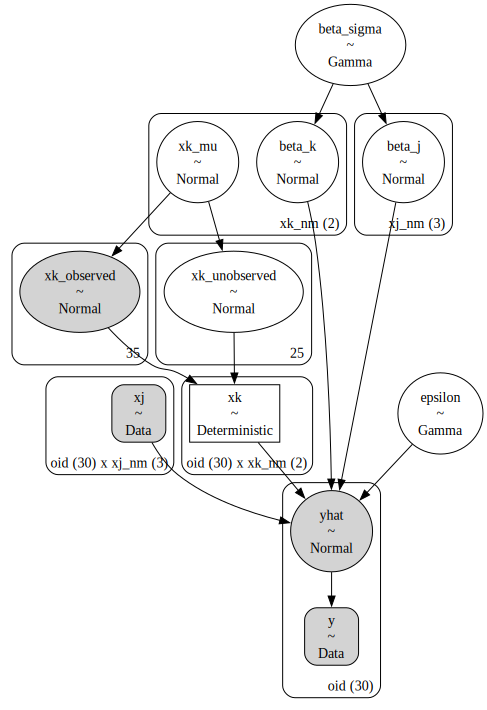

{'unobserved': [xk_mu ~ Normal(0, 1),
  xk_unobserved,
  beta_sigma ~ Gamma(10, f()),
  beta_j ~ Normal(0, beta_sigma),
  beta_k ~ Normal(0, beta_sigma),
  epsilon ~ Gamma(50, f()),
  xk ~ Unknown(f(xk_observed, xk_unobserved))],
 'observed': [xk_observed,
  yhat ~ Normal(f(beta_j, beta_k, xk_observed, xk_unobserved), epsilon)]}

point={'xk_mu': array([0., 0.]), 'xk_unobserved': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), 'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0.]), 'beta_k': array([0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'xk_mu': array([0., 0.]), 'xk_unobserved': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), 'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0.]), 'beta_k': array([0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [34]:
display(pm.model_to_graphviz(mdla, formatting="plain"))
display(dict(unobserved=mdla.unobserved_RVs, observed=mdla.observed_RVs))
assert_no_rvs(mdla.logp())
mdla.debug(fn="logp", verbose=True)
mdla.debug(fn="random", verbose=True)

**Observe:**

+ We have two new auto-created nodes `xk_observed` (observed data) and `xk_unobserved` (unobserved free RV), which 
  each have same distribution as we specified for `xk`
+ The original `xk` is now represented by a new `Deterministic` node with a function of the two (concatenation and reshaping)
+ In particular note `xk_unobserved` has a new, flattened shape with length equal to the count of NaNs in the relevant 
  features $k$, and it loses the `dims` that we assigned to `xk`. This is an unhelpful current limitation and means we
  have to do some indexing to recover the PPC values later

## 2.2 Sample Prior Predictive, View Diagnostics

In [35]:
kws = dict(samples=2000, return_inferencedata=True, random_seed=42)
with mdla:
    ida = pm.sample_prior_predictive(
        var_names=RVS_PPC + RVS_PRIOR + RVS_K + RVS_XK + RVS_XK_UNOBS, **kws
    )

Sampling: [beta_j, beta_k, beta_sigma, epsilon, xk_mu, xk_observed, xk_unobserved, yhat]


### 2.2.1 In-Sample Prior PPC (Retrodictive Check)

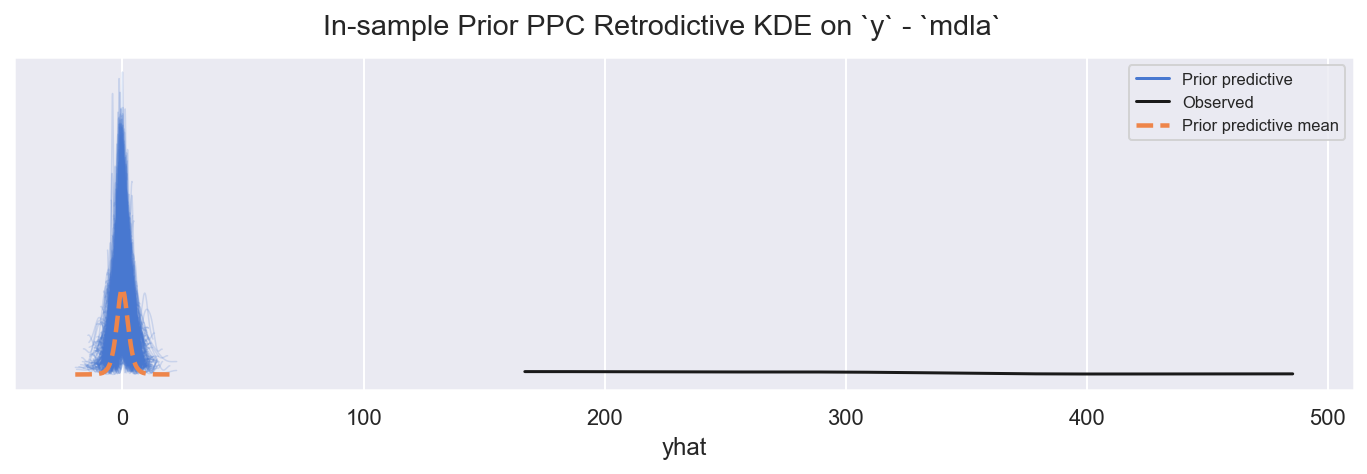

In [36]:
f = plot_ppc_retrodictive(ida, grp="prior", rvs=["yhat"], mdlnm="mdla", ynm="y")

**Observe:**

+ Values are wrong as expected, but range is reasonable

### 2.2.2 Quick look at selected priors

#### Coefficients etc

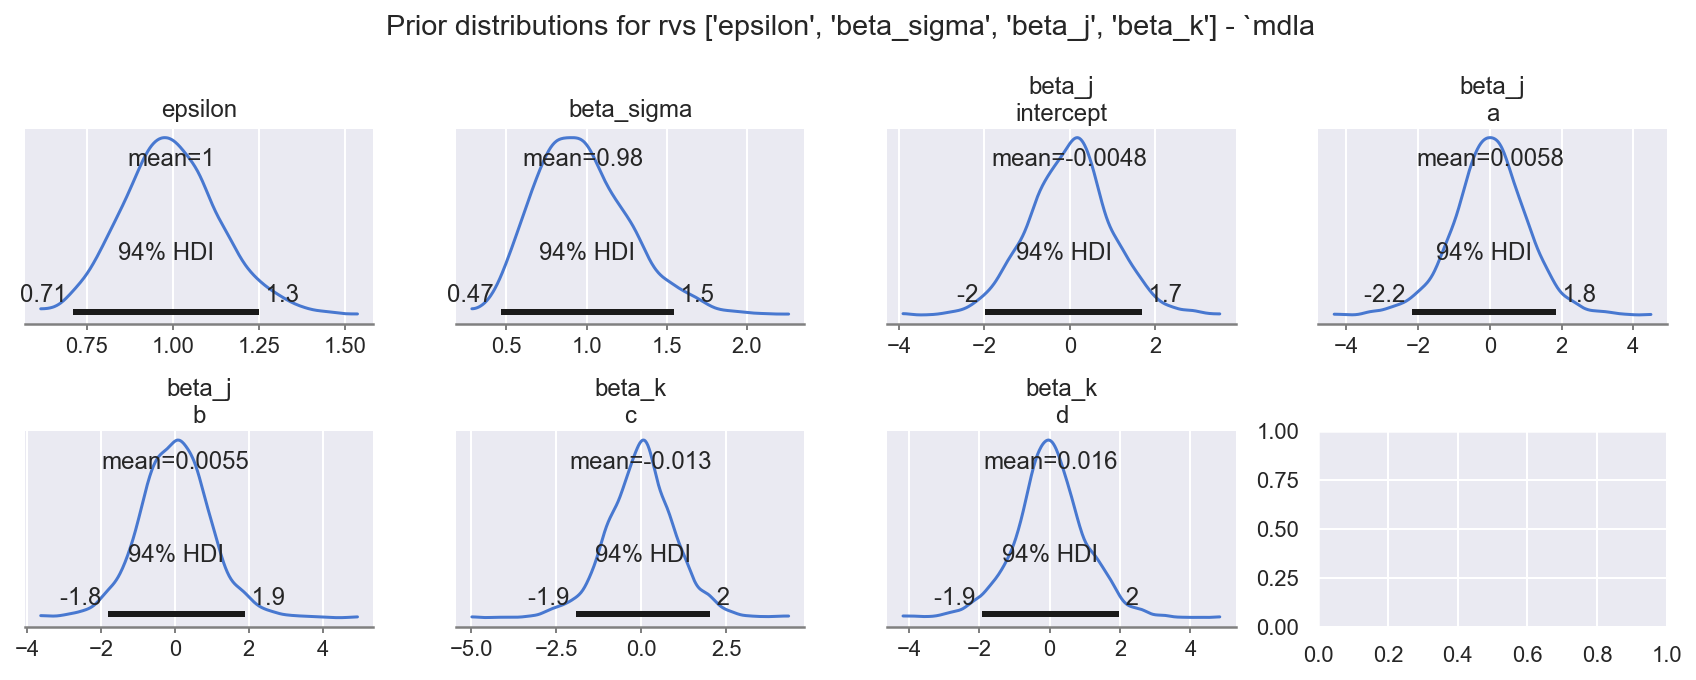

In [37]:
f = plot_krushke(ida, "prior", rvs=RVS_PRIOR, mdlnm="mdla", n=1 + 1 + 3 + 2, nrows=2)

**Observe:**

+ Model priors `beta_sigma`, `beta_j: (levels)`, `beta_k: (levels)`, `epsilon` all have reasonable prior ranges as specified

#### Hierarchical values $\mu_{k}$ for missing data in $\mathbb{x}_{k}$

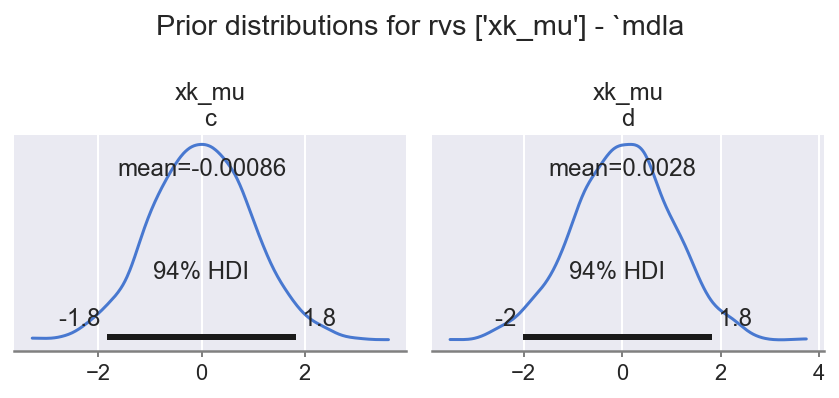

In [38]:
f = plot_krushke(ida, "prior", RVS_K, mdlnm="mdla", n=2, nrows=1)

**Observe:**

+ Data imputation hierarchical priors `xk_mu (levels)` have reasonable prior ranges as specified

#### The values of missing data in $x_{k}$ (`xk_unobserved`)

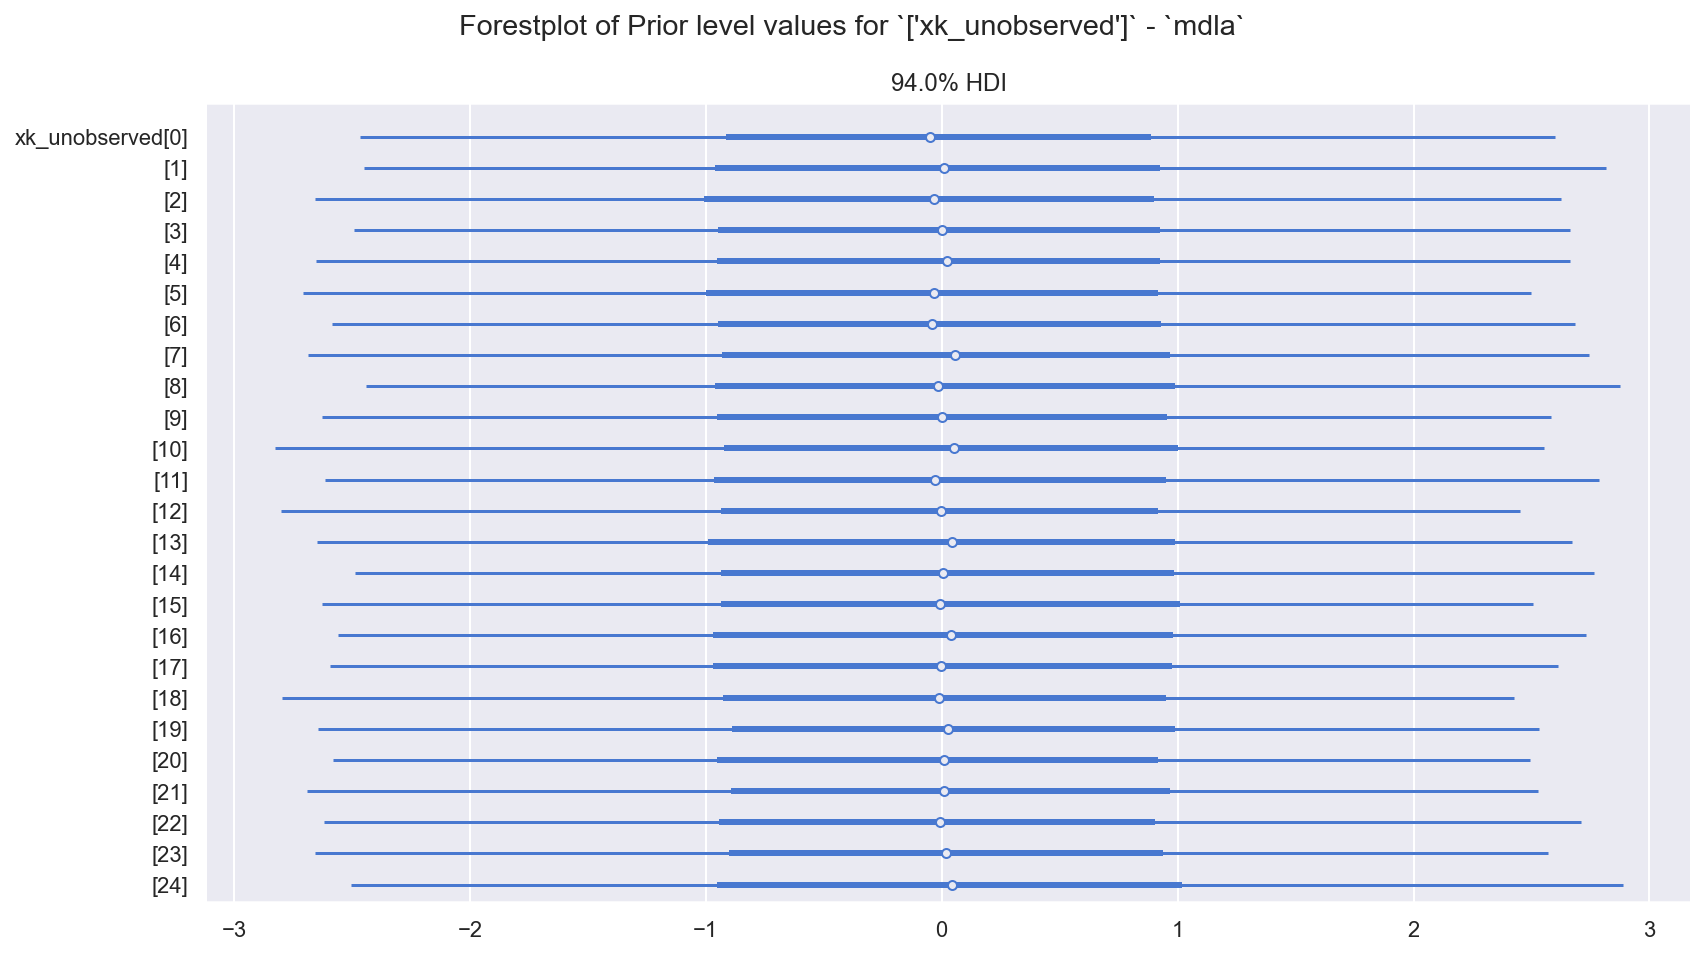

In [39]:
f = plot_forest(ida, "prior", RVS_XK_UNOBS, "mdla")

**Observe:**

+ Prior values for the auto-imputed data `xk_unobserved` are of course all the same, and in reasonable ranges as specified
+ Note again that this is a flattened RV with length equal to the count of NaNs in features `c` and `d`

## 2.3 Sample Posterior, View Diagnostics

### 2.3.1 Sample Posterior and PPC

In [40]:
with mdla:
    ida.extend(pm.sample(**SAMPLE_KWS), join="right")
    ida.extend(
        pm.sample_posterior_predictive(trace=ida.posterior, var_names=RVS_PPC),
        join="right",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xk_mu, xk_unobserved, beta_sigma, beta_j, beta_k, epsilon]


Output()

Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 37 seconds.
Sampling: [xk_observed, yhat]


Output()

### 2.3.2 View Traces

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.950,0.128,0.725,1.200,0.004,0.003,1148.0,1049.0,1.0
beta_sigma,20.427,0.859,18.772,21.909,0.014,0.010,3741.0,1352.0,1.0
beta_j[intercept],274.030,0.279,273.516,274.546,0.007,0.005,1702.0,1466.0,1.0
beta_j[a],8.228,0.361,7.592,8.964,0.011,0.008,1183.0,1429.0,1.0
beta_j[b],-57.873,0.292,-58.431,-57.334,0.007,0.005,1662.0,1682.0,1.0
beta_k[c],18.811,0.343,18.177,19.450,0.009,0.007,1314.0,1327.0,1.0
beta_k[d],59.966,0.265,59.441,60.434,0.006,0.004,1952.0,1276.0,1.0
xk_mu[c],-0.093,0.203,-0.495,0.272,0.004,0.004,2255.0,1638.0,1.0
xk_mu[d],0.028,0.184,-0.288,0.402,0.003,0.004,3811.0,1572.0,1.0


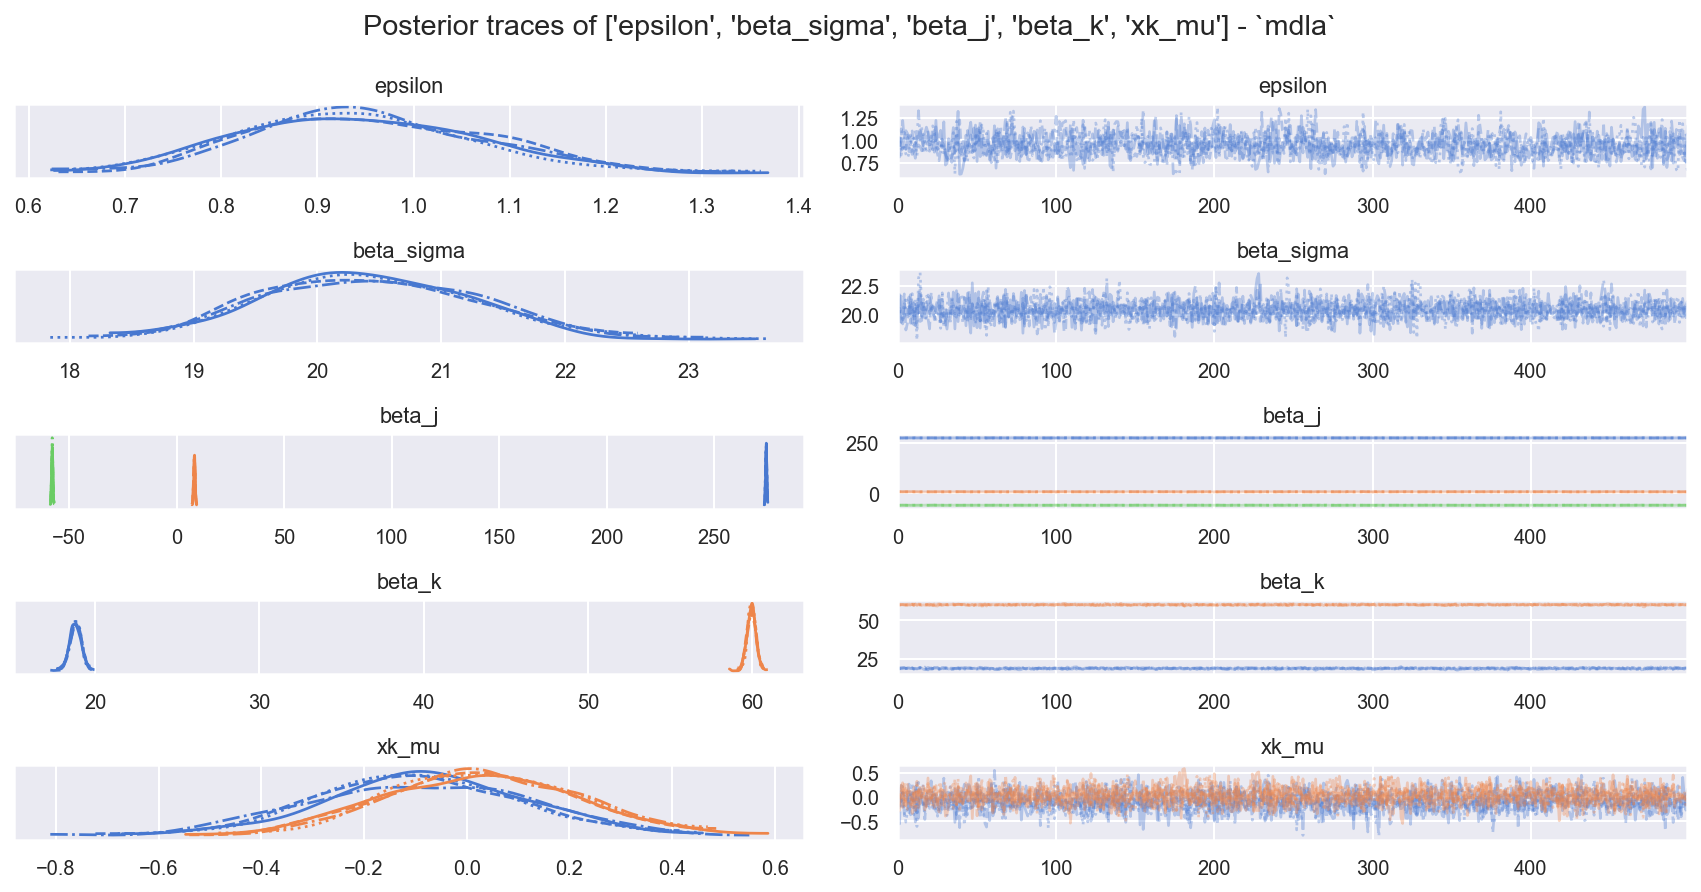

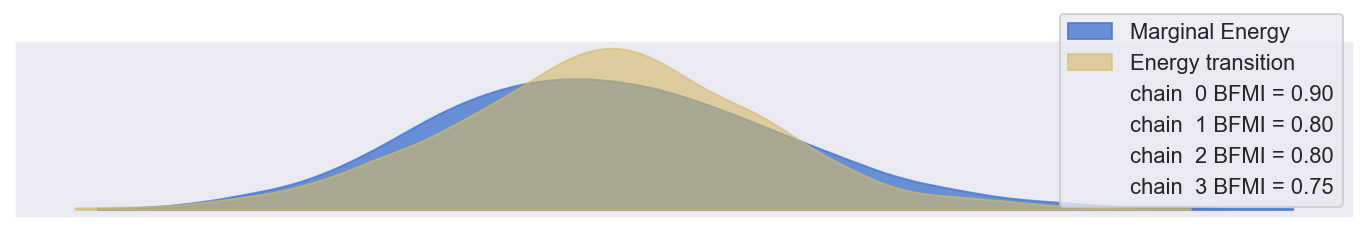

In [41]:
f = plot_traces_and_display_summary(ida, rvs=RVS_PRIOR + RVS_K, mdlnm="mdla", energy=True)

**Observe:**

+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks a little mismatched, a whilst `E-BFMI > 0.3` so is
  [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi), note the
  values are quite low. This is an effect of the missing data

### 2.3.3 In-Sample Posterior PPC (Retrodictive Check)

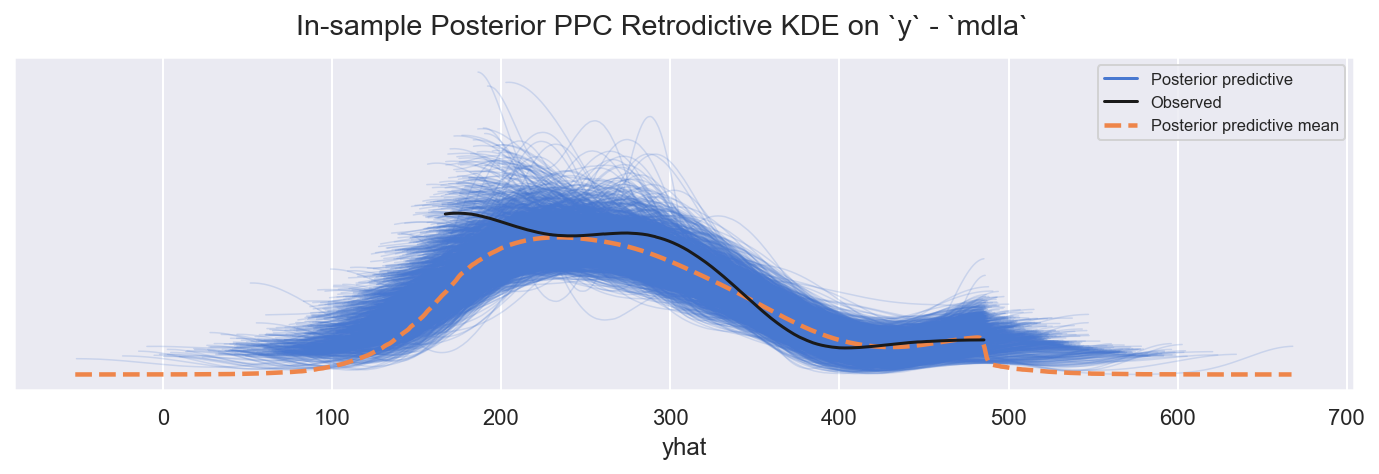

In [42]:
f = plot_ppc_retrodictive(ida, grp="posterior", rvs=["yhat"], mdlnm="mdla", ynm="y")

**Observe:**

+ In-sample PPC `yhat` tracks the observed `y` moderately well: slightly overdispersed, perhaps a likelihood
  with fatter tails would be more appropriate (e.g. StudentT)

### 2.3.4 In-Sample PPC LOO-PIT

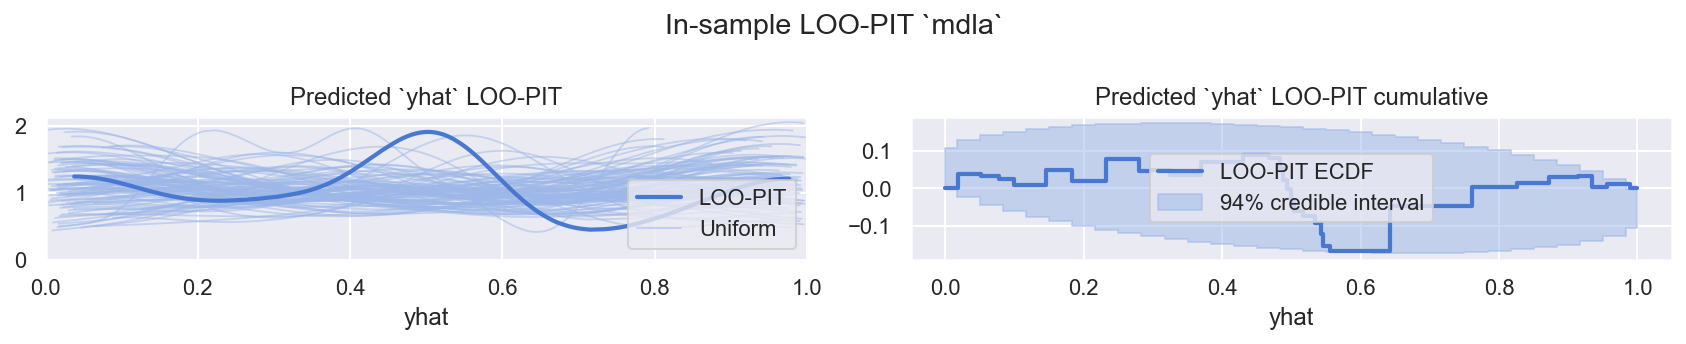

In [43]:
f = plot_loo_pit(ida, "mdla")

**Observe:**

+ `LOO-PIT` looks good, again slightly overdispersed but acceptable for use

### 2.3.5 Compare Log-Likelihood vs Other Models

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl0,0,-44.980281,5.315310,0.000000,0.933953,3.746351,0.000000,True,log
mdla,1,-51.610536,16.076359,6.630255,0.066047,1.586763,3.538735,True,log


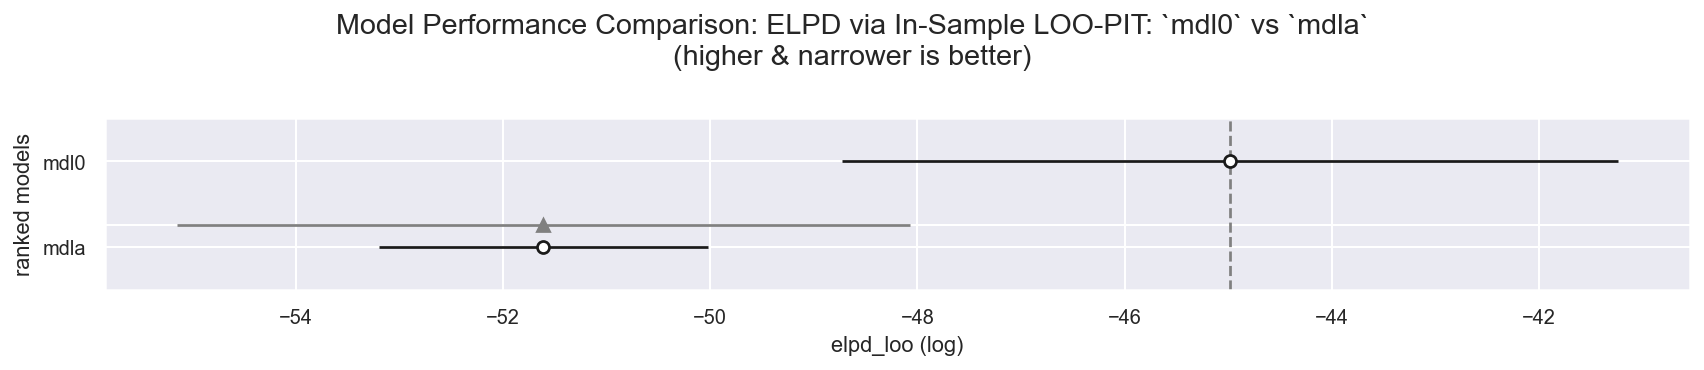

In [44]:
def plot_compare_log_likelihood(idatad: dict, yhat: str = "yhat") -> plt.Figure:
    """Convenience to plot comparison for a dict of idatas"""
    dfcomp = az.compare(idatad, var_name=yhat, ic="loo", method="stacking", scale="log")
    f, axs = plt.subplots(1, 1, figsize=(12, 2 + 0.3 * len(idatad)))
    _ = az.plot_compare(dfcomp, ax=axs, title=False, textsize=10, legend=False)
    _ = f.suptitle(
        "Model Performance Comparison: ELPD via In-Sample LOO-PIT: `"
        + "` vs `".join(list(idatad.keys()))
        + "`\n(higher & narrower is better)"
    )
    _ = f.tight_layout()
    display(dfcomp)
    return f


f = plot_compare_log_likelihood(idatad={"mdl0": id0, "mdla": ida})

**Observe:**

+ Very interesting: our auto-imputing `Model A` does of course suffer in comparison to `Model 0` which has the benefit 
  of the complete dataset (no missing values), but it's not that much worse, and (of course) we've been able to handle
  missing values in the in-sample data!

## 2.4 Evaluate Posterior Parameters

### 2.4.1 Coefficients etc

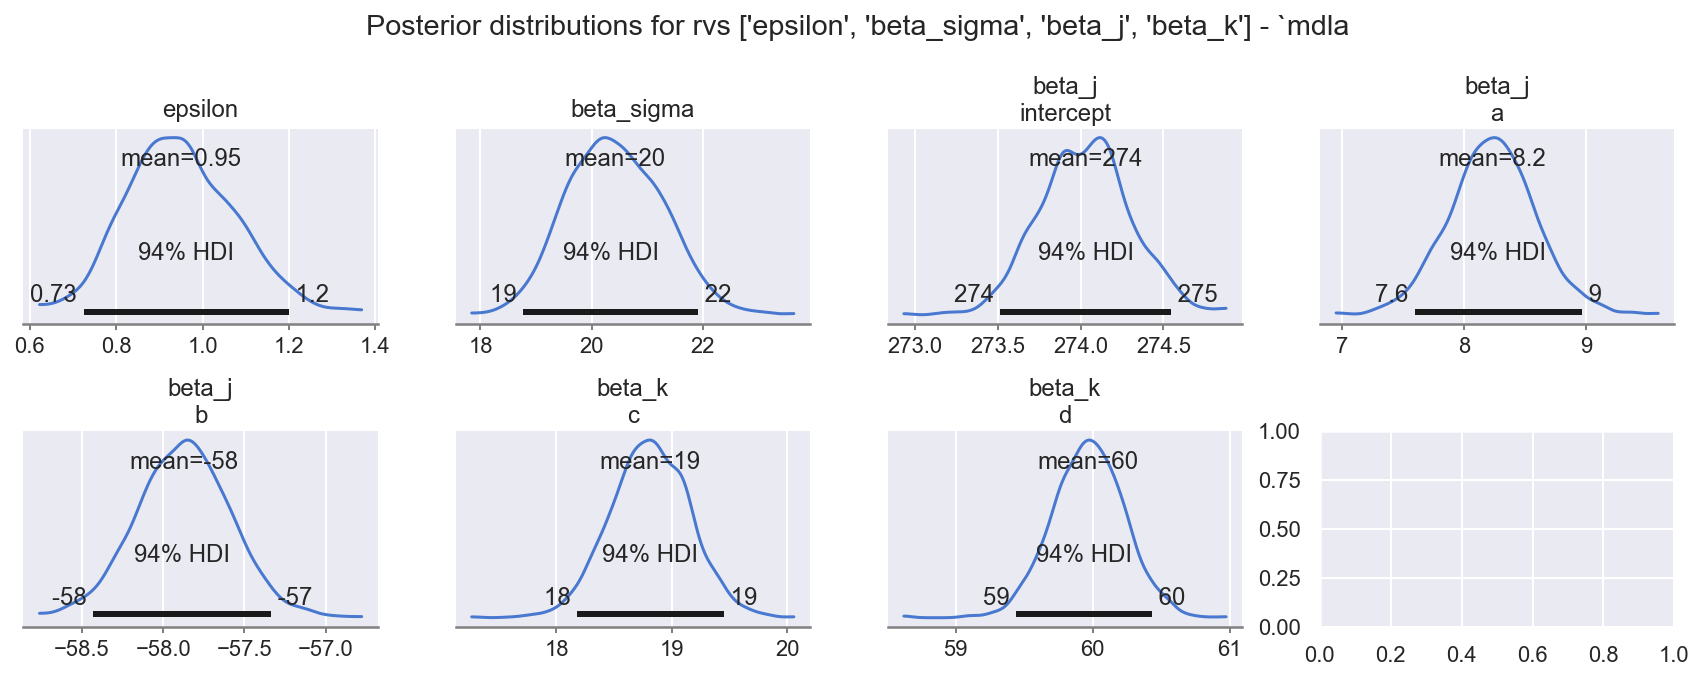

In [45]:
f = plot_krushke(ida, "posterior", RVS_PRIOR, mdlnm="mdla", n=1 + 1 + 3 + 2, nrows=2)

**Observe:**

+ Model coeffs `beta_sigma`, `beta_j: (levels)`, `beta_k: (levels)`, `epsilon` all have reasonable prior ranges as specified

#### For interest's sake forestplot the `beta_j` and `beta_k` levels to compare relative effects

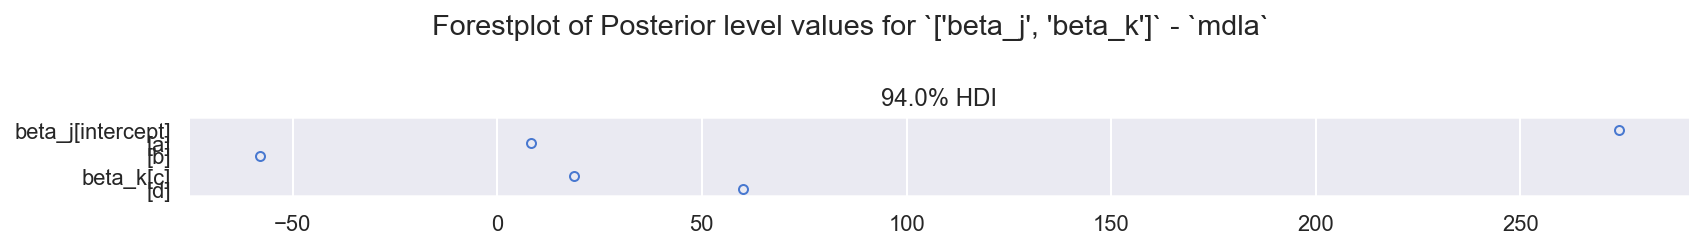

In [46]:
f = plot_forest(ida, grp="posterior", rvs=["beta_j", "beta_k"], mdlnm="mdla")

**Observe:**

+ Very tight and distinct posterior distributions
+ Loosely compare this to the same plot for `mdl0` in $\S1.4$ above: 

### 2.4.2 Hierarchical values for missing data in $\mathbb{x}_{k}$

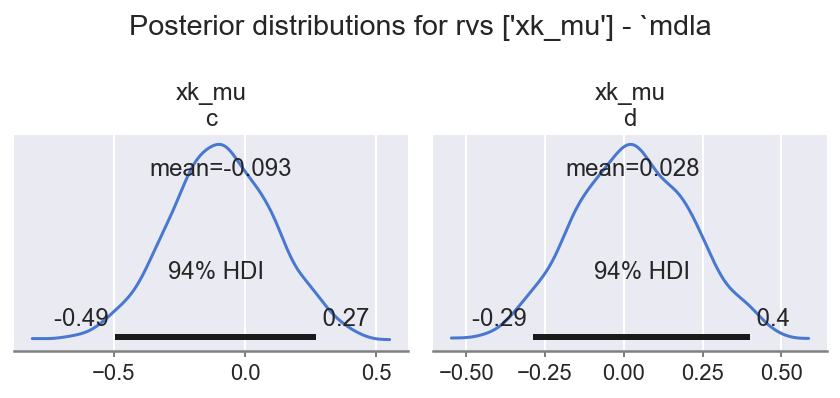

In [47]:
f = plot_krushke(ida, "posterior", RVS_K, mdlnm="mdla", n=2, nrows=1)

**Observe:**

+ Data imputation hierarchical priors haven't moved far from `0`, which is reasonable because the missingness is at random
+ However, they do show slight differences which is encouraging of them picking up the inherent differences in the 
  primary raw data due to `REFVALS_X_MU`

### 2.4.3 View auto-imputed values of missing data in $x_{k}$ (`xk_unobserved`)

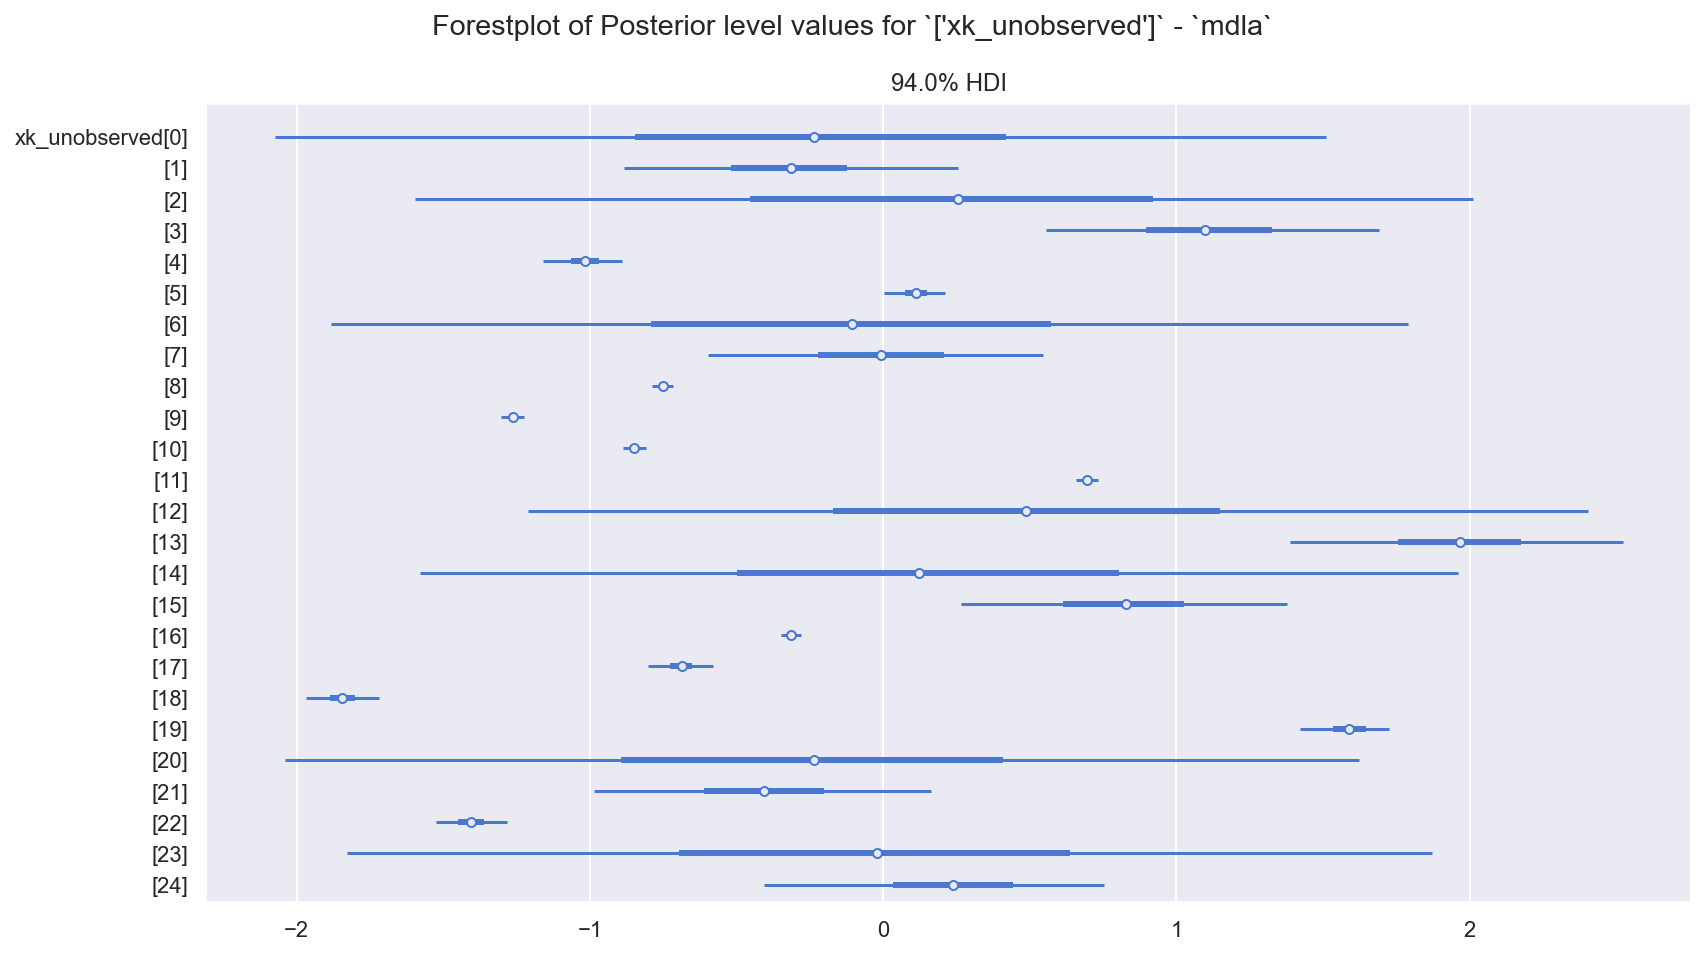

In [48]:
f = plot_forest(ida, "posterior", RVS_XK_UNOBS, "mdla")

**Observe:**

+ We have used our model to autoimpute missing values in `xk_unobserved`, with quantified uncertainty
+ With the appropriate post-model indexing, we can use these as posterior predictions of the true values of the 
  missing data
+ We'll show that indexing and a special comparison to the synthetic known values next

### 2.4.4 In-sample: Compare auto-imputed values $x_{k}$ `xk_unobserved` to known true values

**NOTE**

+ We can only compare because it's a synthetic dataset where we created those complete (full) values in `dfraw` above

#### Create index to extract appropriate obs from `xk`, because `xk_unobserved` doesn't have the right dims indexes

In [49]:
dfx_train_xk = (
    dfx_train.loc[:, ["c", "d"]]
    .reset_index()
    .melt(id_vars=["oid"], var_name="xk_nm", value_name="xk")
    .set_index(["oid", "xk_nm"])
)
idx_xk_unobs = dfx_train_xk.loc[dfx_train_xk["xk"].isnull()].index

##### Extract from PPC idata , isolate via index, transform back into data domain

In [50]:
df_mns_sdevs = pd.DataFrame({"mn": MNS, "sdev": SDEVS}, index=["a", "b", "c", "d"])
df_mns_sdevs.index.name = "xk_nm"

df_xk_unobs = (
    az.extract(ida, group="posterior", var_names=RVS_XK)
    .to_dataframe()
    .drop(["chain", "draw"], axis=1)
    .reset_index()
    .set_index(["oid", "xk_nm"])
    .loc[idx_xk_unobs]
)
df_xk_unobs = (
    pd.merge(df_xk_unobs.reset_index(), df_mns_sdevs.reset_index(), how="left", on=["xk_nm"])
    .set_index(["oid", "xk_nm"])
    .sort_index()
)
df_xk_unobs["xk_unobs_ppc_data_domain"] = (df_xk_unobs["xk"] * df_xk_unobs["sdev"]) + df_xk_unobs[
    "mn"
]
df_xk_unobs.head()

chain  draw        xk        mn      sdev  xk_unobs_ppc_data_domain
oid xk_nm                                                                     
o00 c          0     0  0.347502  9.491124  0.648293                  9.716407
    c          0     1 -1.230997  9.491124  0.648293                  8.693077
    c          0     2  0.812971  9.491124  0.648293                 10.018166
    c          0     3 -0.332310  9.491124  0.648293                  9.275689
    c          0     4  1.140414  9.491124  0.648293                 10.230446

##### Attach real values (only available because synthetic)

In [51]:
dfraw_xk = (
    dfraw[["c", "d"]]
    .reset_index()
    .melt(id_vars=["oid"], var_name="xk_nm", value_name="xk_unobs_true_val")
    .set_index(["oid", "xk_nm"])
)

df_xk_unobs = pd.merge(
    df_xk_unobs, dfraw_xk.loc[idx_xk_unobs], how="left", left_index=True, right_index=True
)
df_xk_unobs.head()

chain  draw        xk        mn      sdev  \
oid xk_nm                                              
o00 c          0     0  0.347502  9.491124  0.648293   
    c          0     1 -1.230997  9.491124  0.648293   
    c          0     2  0.812971  9.491124  0.648293   
    c          0     3 -0.332310  9.491124  0.648293   
    c          0     4  1.140414  9.491124  0.648293   

           xk_unobs_ppc_data_domain  xk_unobs_true_val  
oid xk_nm                                               
o00 c                      9.716407          10.456775  
    c                      8.693077          10.456775  
    c                     10.018166          10.456775  
    c                      9.275689          10.456775  
    c                     10.230446          10.456775

##### Force dtypes for plotting

In [52]:
df_xk_unobs = df_xk_unobs.reset_index()
df_xk_unobs["oid"] = pd.Categorical(df_xk_unobs["oid"])
df_xk_unobs["xk_nm"] = pd.Categorical(df_xk_unobs["xk_nm"])
df_xk_unobs.set_index(["oid", "xk_nm"], inplace=True)
df_xk_unobs.head()

chain  draw        xk        mn      sdev  \
oid xk_nm                                              
o00 c          0     0  0.347502  9.491124  0.648293   
    c          0     1 -1.230997  9.491124  0.648293   
    c          0     2  0.812971  9.491124  0.648293   
    c          0     3 -0.332310  9.491124  0.648293   
    c          0     4  1.140414  9.491124  0.648293   

           xk_unobs_ppc_data_domain  xk_unobs_true_val  
oid xk_nm                                               
o00 c                      9.716407          10.456775  
    c                      8.693077          10.456775  
    c                     10.018166          10.456775  
    c                      9.275689          10.456775  
    c                     10.230446          10.456775

##### Plot posterior `xk_unobserved` vs known true values (only possible in this synthetic example)

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

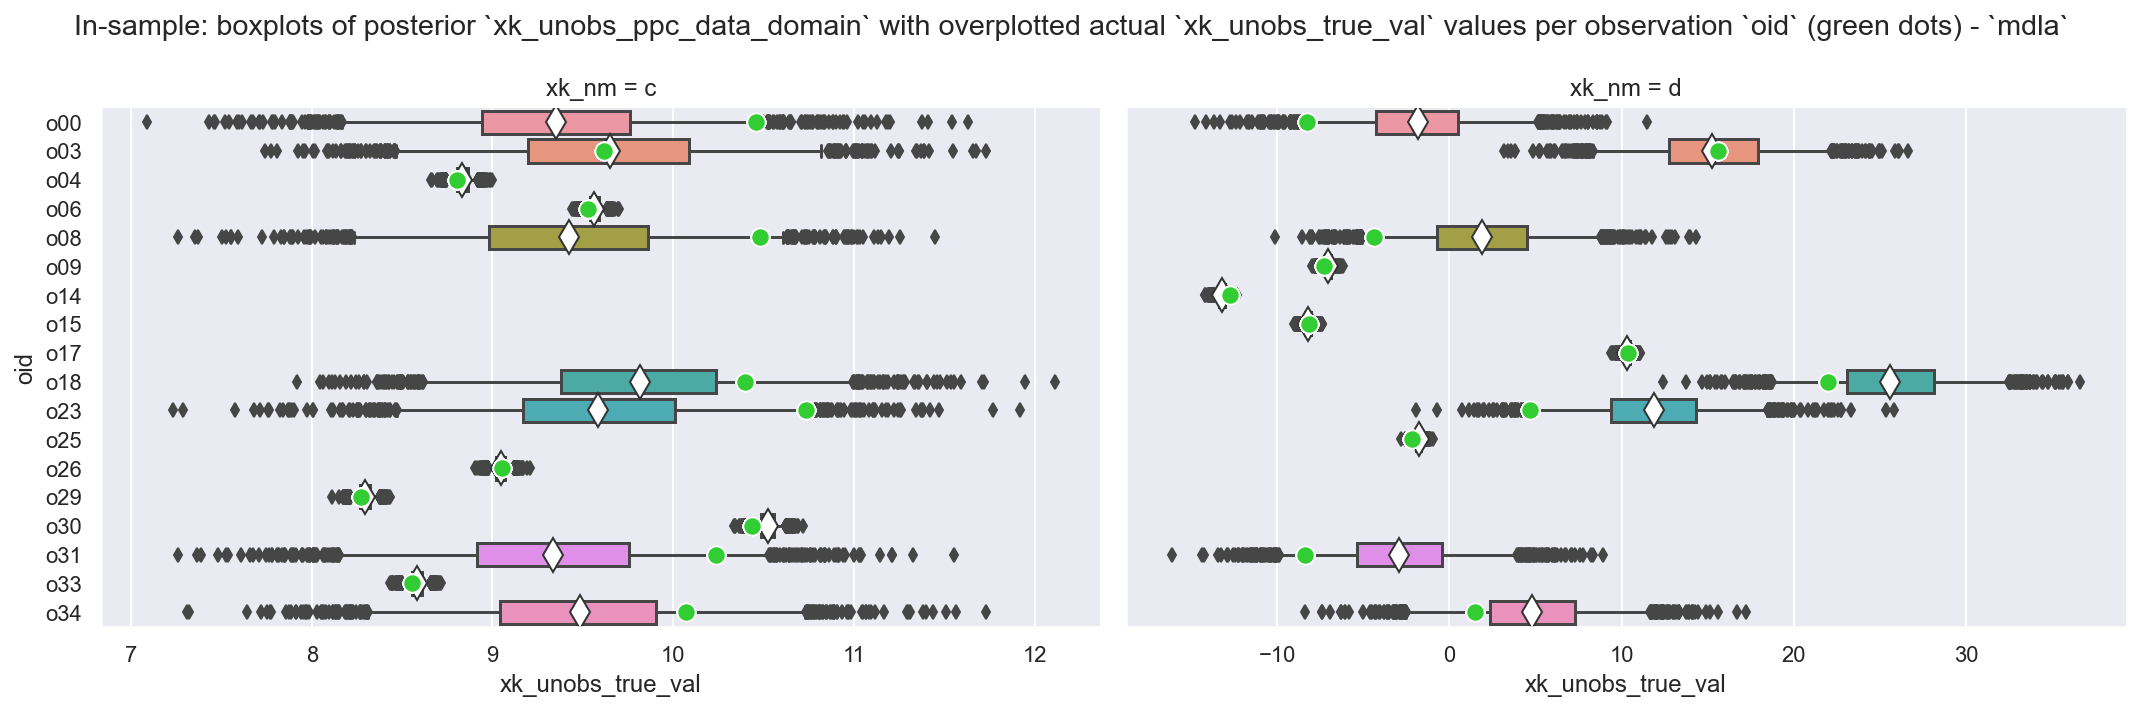

In [53]:
def plot_xkhat_vs_xk(
    df_xk: pd.DataFrame,
    xkhat: str = "xk_unobs_ppc_data_domain",
    x: str = "xk_unobs_true_val",
    mdlnm: str = "mdla",
    in_samp: bool = True,
) -> plt.Figure:
    """Convenience plot forecast xkhat with overplotted x true val (from synthetic set)"""
    g = sns.catplot(
        x=xkhat,
        y="oid",
        col="xk_nm",
        data=df_xk.reset_index(),
        **KWS_BOX,
        height=5,
        aspect=1.5,
        sharex=False,
    )
    _ = g.map(sns.scatterplot, x, "oid", **KWS_SCTR, zorder=100)
    s = "In-sample" if in_samp else "Out-of-sample"
    _ = g.fig.suptitle(
        f"{s}: boxplots of posterior `{xkhat}` with overplotted actual `{x}` values"
        + f" per observation `oid` (green dots) - `{mdlnm}`"
    )
    _ = g.tight_layout()
    return g.fig


_ = plot_xkhat_vs_xk(df_xk_unobs, mdlnm="mdla")

**Observe:**

+ Here's our auto-imputed posterior distributions (boxplots) for the missing data on the in-sample dataset `dfx_train`
+ These are a (very helpful!) side-effect of our model construction and let us fill-in the real-world missing values for
  `c`, and `d` in `df_train`
+ Some observations (e.g. `o00`, `o03`) have missing values in both `c` and `d`, others (e.g `o04`, `o06`) have only one
+ We also overplot the known true values from the synthetic dataset: and the match is close for all: usually 
  well-within the HDI94
+ Where observations have more than one missing value (e.g. `o00`, `o8`, `o18`, `023` are good examples), we see the
  possibility of a lack of identifiability: this is an interesting and not easily avoided side-effect of the data and
  model architecture, and in the real-world we might seek to mitigate through removing observations or features.

## 2.5 Create PPC Forecast on `dfx_holdout` set

**IMPLEMENTATION NOTE**

The following process is a bit of a hack:

1. Firstly: Re-specify the model entirely, using `dfx_holdout`, because doing `mdla.set_data` 
   doesn't update the `np.ma.masked_array`, and as noted above $\S 2.1$ **Build Model Object** we can't put `nans` or 
  a `masked_array` into a `pm.Data`
1. Secondly: Sample_ppc the `xk_unobserved`, because this is a precursor to computing `yhat`, and we can't specify
   a conditional order in `sample_posterior_predictive`
2. Thirdly: Use those predictions to sample_ppc the `yhat`

**REALITIES**

+ This process is suboptimal for a real-world scenario wherein we want to forecast new incoming data, because we have to
  keep re-specifying the model in Step 1 (which opens opportunities for simple human error), and Steps 2 & 3 involve 
  manipulations of idata objects, which is a faff
+ It should still be suitable for a relatively slow, (potentially batched) forecasting process on the order of seconds, 
  not sub-second
+ In any case, if this were to be deployed to handle a stream of sub-second inputs, a much simpler way to rectify the 
  situation would be to ensure proper data validation / hygiene upstream and require no missing data!

### 2.5.1 Firstly: Rebuild model entirely, using `dfx_holdout`

In [54]:
COORDS_H = deepcopy(COORDS)
COORDS_H["oid"] = dfx_holdout.index.values

with pm.Model(coords=COORDS_H) as mdla_h:
    # 0. create (Mutable)Data containers for obs (Y, X)
    # NOTE: You could use mdla.set_data to change these pm.Data containers...
    y = pm.Data("y", dfx_holdout[ft_y].values, dims="oid")
    xj = pm.Data("xj", dfx_holdout[FTS_XJ].values, dims=("oid", "xj_nm"))

    # NOTE: ... but there's no way to put a nan-containing array into a pm.Data,
    # nor a masked_array, so you can't change this construction easily
    xk_ma = np.ma.masked_array(
        dfx_holdout[FTS_XK].values, mask=np.isnan(dfx_holdout[FTS_XK].values)
    )

    # same code as above for mdla
    # 1. create auto-imputing likelihood for missing data values
    xk_mu = pm.Normal("xk_mu", mu=0.0, sigma=1, dims="xk_nm")
    xk = pm.Normal("xk", mu=xk_mu, sigma=1.0, observed=xk_ma, dims=("oid", "xk_nm"))

    # 2. define priors for contiguous and auto-imputed data
    b_s = pm.Gamma("beta_sigma", alpha=10, beta=10)  # E ~ 1
    bj = pm.Normal("beta_j", mu=0, sigma=b_s, dims="xj_nm")
    bk = pm.Normal("beta_k", mu=0, sigma=b_s, dims="xk_nm")

    # 4. define evidence
    epsilon = pm.InverseGamma("epsilon", alpha=11, beta=10)
    lm = pt.dot(xj, bj.T) + pt.dot(xk, bk.T)
    _ = pm.Normal("yhat", mu=lm, sigma=epsilon, observed=y, dims="oid")

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in xk contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


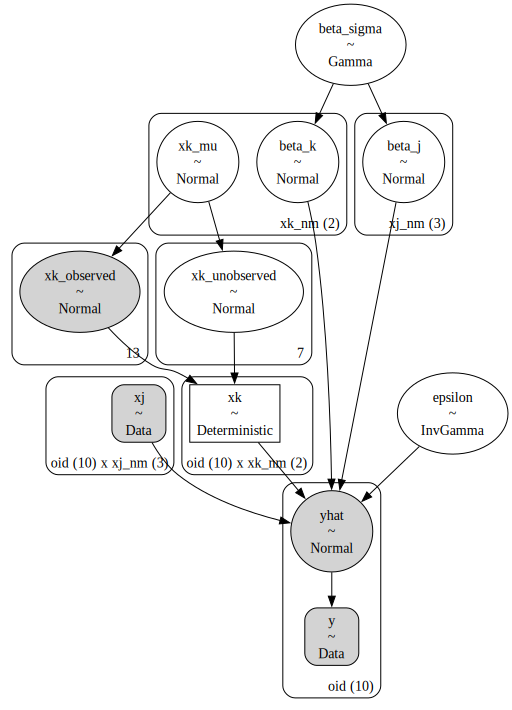

point={'xk_mu': array([0., 0.]), 'xk_unobserved': array([0., 0., 0., 0., 0., 0., 0.]), 'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0.]), 'beta_k': array([0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'xk_mu': array([0., 0.]), 'xk_unobserved': array([0., 0., 0., 0., 0., 0., 0.]), 'beta_sigma_log__': array(0.), 'beta_j': array([0., 0., 0.]), 'beta_k': array([0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [55]:
display(pm.model_to_graphviz(mdla_h, formatting="plain"))
assert_no_rvs(mdla_h.logp())
mdla_h.debug(fn="logp", verbose=True)
mdla_h.debug(fn="random", verbose=True)

### 2.5.2 Secondly: sample PPC for missing values `xk_unobserved` in out-of-sample dataset

**NOTE** 

+ Avoid changing `ida`, instead take a deepcopy `ida_h` , remove uneccessary groups, and we'll use that
+ We won't create a bare `az.InferenceData` then add groups, because we have to add all sorts of addtional subtle 
  info to the object. Easier to copy and remove groups
+ The `xarray` indexing in `posterior` will be wrong (set according to `dfx_train`, rather than `dfx_holdout`),
  specifically dimension `oid` and coordinate `oid`.
+ Changing things like this inside an `xarray.Dataset` is a total nightmare so we won't attempt to change them. It won't
  matter in this case anyway because we won't refer to the `posterior`.

In [56]:
ida_h = deepcopy(ida)
# leave only posterior
del (
    ida_h.log_likelihood,
    ida_h.sample_stats,
    ida_h.prior,
    ida_h.prior_predictive,
    ida_h.posterior_predictive,
    ida_h.observed_data,
    ida_h.constant_data,
)
ida_h

Inference data with groups:
	> posterior

In [57]:
# NOTE for later clarity and to avoid overwriting, temporarily save posterior
# [xk, xk_unobserved] into group `posterior_predictive`` and remove any more
# unecessary groups

with mdla_h:
    ida_h.extend(
        pm.sample_posterior_predictive(
            trace=ida_h.posterior, var_names=["xk_unobserved", "xk"], predictions=False
        ),
        join="right",
    )

del ida_h.observed_data, ida_h.constant_data
ida_h

Sampling: [xk_observed, xk_unobserved]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive

### 2.5.3 Thirdly: sub the predictions for `xk_unobserved` into idata and sample PPC for `yhat`

In [58]:
# NOTE overwrite [xk, xk_observed] in group `posterior` and sample yhat into new
# group `predictions`
ida_h.posterior.update({"xk_unobserved": ida_h.posterior_predictive.xk_unobserved})
ida_h.posterior.update({"xk": ida_h.posterior_predictive.xk})

with mdla_h:
    ida_h.extend(
        pm.sample_posterior_predictive(trace=ida_h.posterior, var_names=["yhat"], predictions=True),
        join="right",
    )

# NOTE copy [xk, xk_observed] into group `predictions` to make it clear that these
# dont fit in group `posterior` (the dims / coords issue), and drop groups
# `posterior_predictive` and `posterior`
ida_h.predictions.update({"xk_unobserved": ida_h.posterior_predictive.xk_unobserved})
ida_h.predictions.update({"xk": ida_h.posterior_predictive.xk})

del ida_h.posterior_predictive, ida_h.posterior
ida_h

Sampling: [xk_observed, yhat]


Output()

Inference data with groups:
	> predictions
	> predictions_constant_data

**Observe**

+ Finally in `ida_h` we have Datasets for `predictions` and `predictions_constant_data` as if we'd done only one step
+ `mdla_h` can be safely removed

### 2.5.4 Out-of-sample: Compare auto-imputed values $x_{k}$ `xk_unobserved` to known true values

**NOTE**

+ Recall we can only do this because it's a synthetic dataset where we created those complete (full) values in `dfraw` above
+ We will show a plot that might surprise the reader...

##### Create index to extract appropriate obs from `xk`, because `xk_unobserved` doesn't have the right dims indexes

In [59]:
dfx_holdout_xk = (
    dfx_holdout.loc[:, ["c", "d"]]
    .reset_index()
    .melt(id_vars=["oid"], var_name="xk_nm", value_name="xk")
    .set_index(["oid", "xk_nm"])
)
idx_h_xk_unobs = dfx_holdout_xk.loc[dfx_holdout_xk["xk"].isnull()].index

##### Extract `xk_unobserved` from PPC idata , isolate via index, transform back into data domain

In [60]:
df_h_xk_unobs = (
    az.extract(ida_h, group="predictions", var_names=["xk"])
    .to_dataframe()
    .drop(["chain", "draw"], axis=1)
    .reset_index()
    .set_index(["oid", "xk_nm"])
    .loc[idx_h_xk_unobs]
)
df_h_xk_unobs = (
    pd.merge(df_h_xk_unobs.reset_index(), df_mns_sdevs.reset_index(), how="left", on=["xk_nm"])
    .set_index(["oid", "xk_nm"])
    .sort_index()
)
df_h_xk_unobs["xk_unobs_ppc_data_domain"] = (
    df_h_xk_unobs["xk"] * df_h_xk_unobs["sdev"]
) + df_h_xk_unobs["mn"]

##### Attach real values (only possible in this synthetic example)

In [61]:
df_h_xk_unobs = pd.merge(
    df_h_xk_unobs, dfraw_xk.loc[idx_h_xk_unobs], how="left", left_index=True, right_index=True
)

##### Force dtypes for plotting

In [62]:
df_h_xk_unobs = df_h_xk_unobs.reset_index()
df_h_xk_unobs["oid"] = pd.Categorical(df_h_xk_unobs["oid"])
df_h_xk_unobs["xk_nm"] = pd.Categorical(df_h_xk_unobs["xk_nm"])
df_h_xk_unobs.set_index(["oid", "xk_nm"], inplace=True)

##### Plot posterior `xk_unobserved` vs known true values (only possible in this synthetic example)

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

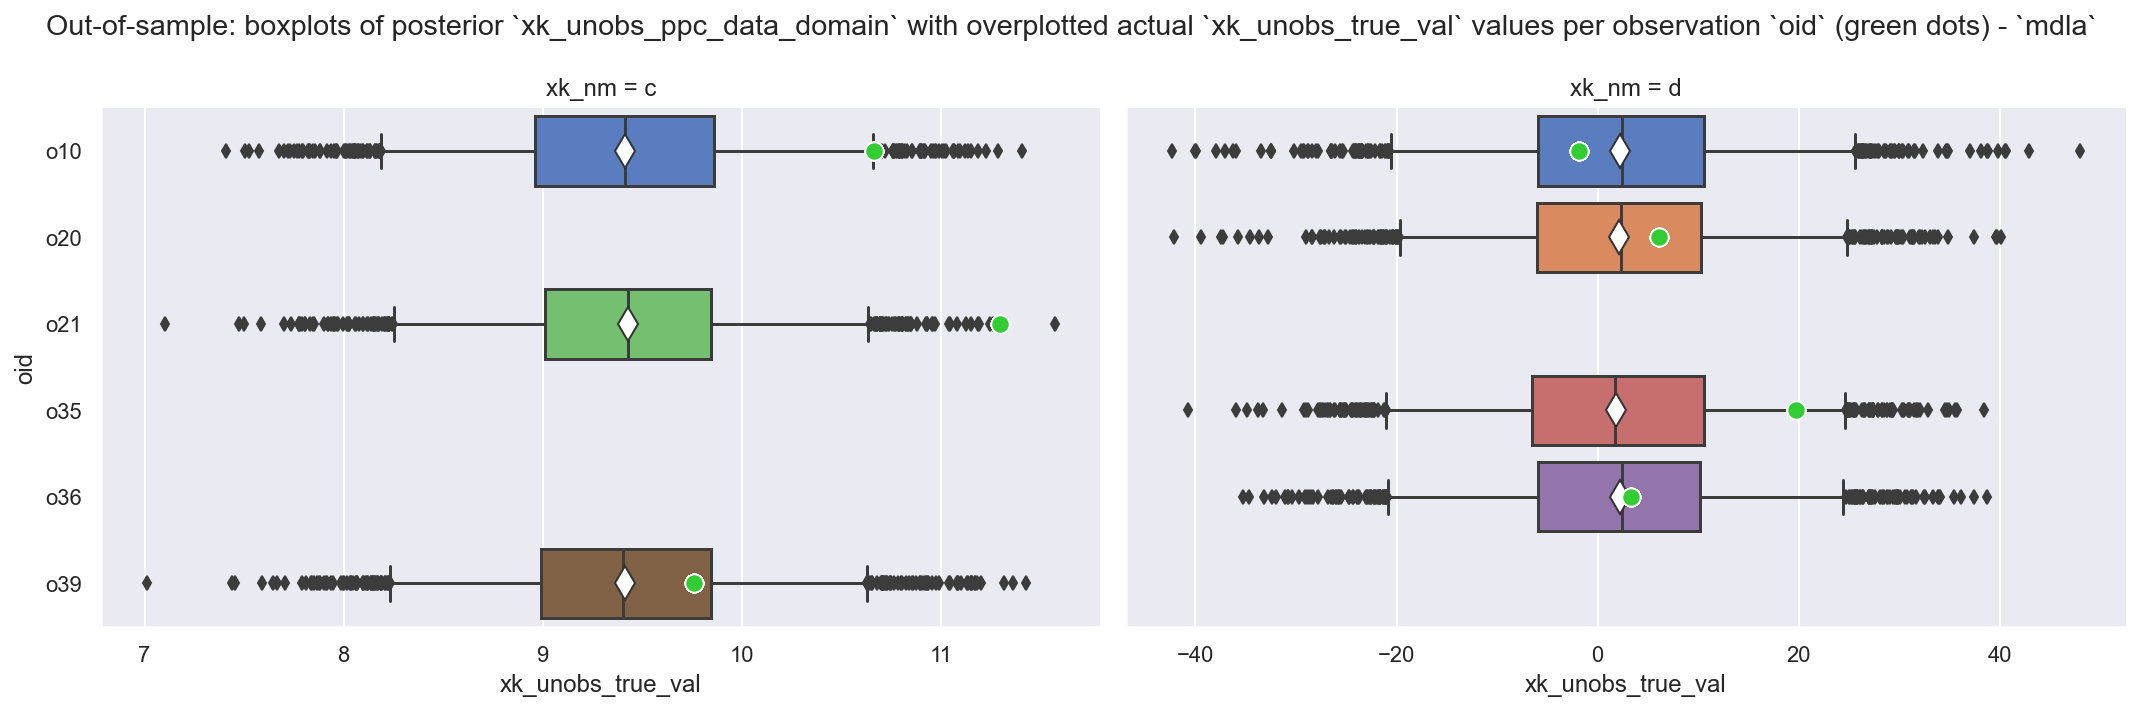

In [63]:
_ = plot_xkhat_vs_xk(df_h_xk_unobs, mdlnm="mdla", in_samp=False)

**Observe:**

+ Excellent: this looks like we have a terrible prediction - but the model is working as expected, and this is helpful
  to illustrate
+ The posterior values of `xk_unobserved` have been pulled from the hierarchical `xk_mu` distributions and are not 
  conditional on anything else, so we get pretty much all the same predicted value
+ This should drive home the understanding that while technically this model **can** handle new missing values,
  and **does** auto-impute values for missing data in an out-of-sample dataset (here `dfx_holdout`), these auto-imputed
  values for `xk_unobserved` **can't** be any more informative than the posterior distribution of the hierachical 
  prior `xk_mu`.

### 2.5.5 Out-of-sample: Compare forecasted $\hat{y}$ `yhat` to known true values

##### Extract `yhat` from PPC idata, and attach real values (only available because it's a `holdout` set)

In [64]:
df_h_y = (
    az.extract(ida_h, group="predictions", var_names=["yhat"])
    .to_dataframe()
    .drop(["chain", "draw"], axis=1)
    .reset_index()
    .set_index(["oid"])
)
df_h_y = pd.merge(df_h_y, df_holdout[["y"]], how="left", left_index=True, right_index=True)
df_h_y.describe().T

,count,mean,std,min,25%,50%,75%,max
chain,20000.0,1.500000,1.118062,0.000000,0.750000,1.500000,2.250000,3.000000
draw,20000.0,249.500000,144.340887,0.000000,124.750000,249.500000,374.250000,499.000000
yhat,20000.0,297.484165,83.436059,14.249407,240.197013,295.910616,353.352564,621.151035
y,20000.0,318.907654,50.573475,260.662351,281.480703,311.909327,343.178076,439.462555


##### Plot posterior `yhat` vs known true values `y` (only available because it's a `holdout` set)

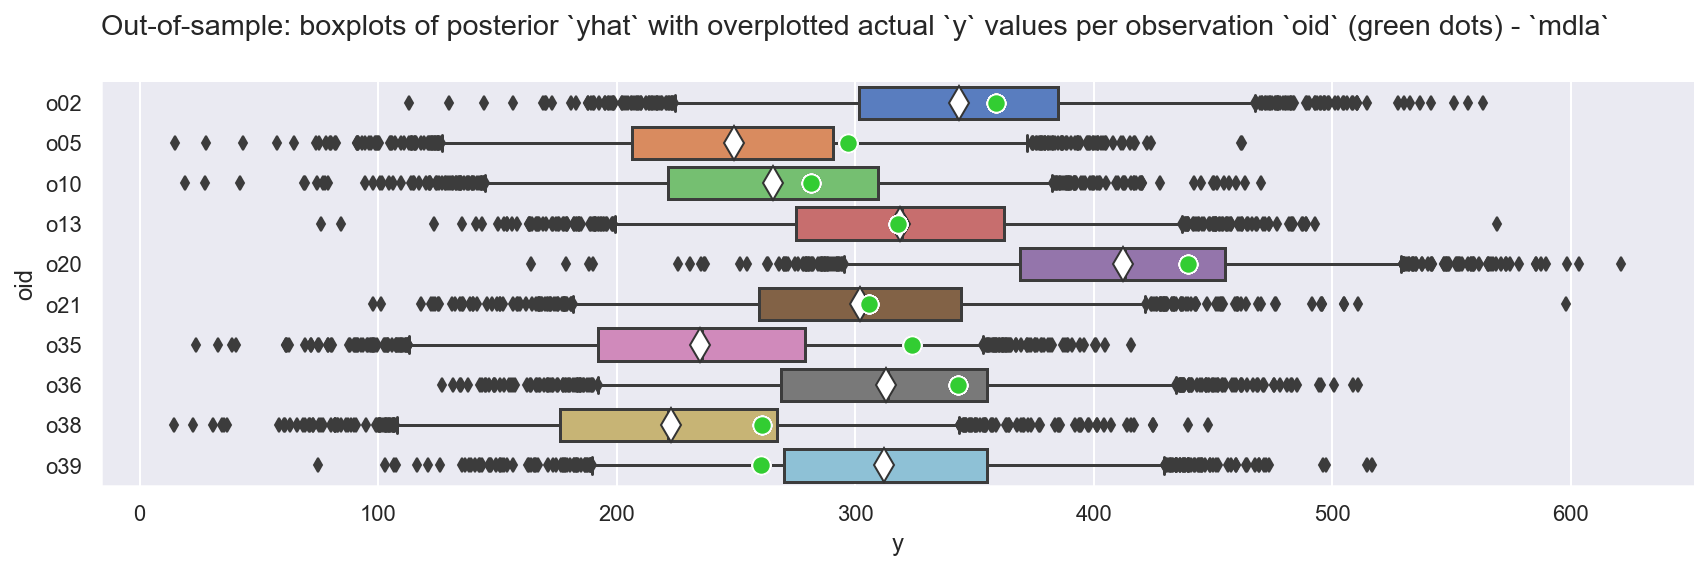

In [65]:
_ = plot_yhat_vs_y(df_h_y)

**Observe:**

+ The predictions `yhat` look pretty close to the true value `y`, usually well-within the HDI94
+ As we would expect, the distributions of `yhat` are useful too: quantifing the uncertainty in prediction and letting us
  make better decisions accordingly.

---

---

# Errata

## Authors

+ Created by [Jonathan Sedar](https://github.com/jonsedar) in Nov 2024

## Reference

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [66]:
# tested running on Google Colab 2024-11-09
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Nov 09 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

pandas    : 2.2.2
pytensor  : 2.25.2
pymc      : 5.16.2
numpy     : 1.26.4
seaborn   : 0.12.2
matplotlib: 3.9.1
arviz     : 0.19.0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::